In [1]:
from sys import path
path.append('../tools')
from tools import gen_inputs_outputs, gen_pair_inputs
from tensorflow import keras
from keras import layers, Sequential, Input, metrics
import matplotlib.pyplot as plt

2024-08-31 09:09:39.155321: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-31 09:09:40.649395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-31 09:09:41.271119: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-31 09:09:41.273788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-31 09:09:42.261160: I tensorflow/core/platform/cpu_feature_gua

In [2]:
# For these calculations, we change the input so that
# the layers are in units of 2
# First create input for a classic model to compare

In [3]:
R = 16
x_train, y_train, S = gen_inputs_outputs(R)

In [4]:
# Creates the unit inputs
def gen_unit_inputs(l):
    return [Input(shape=(2,), name=f'unit_{i}') for i in range(l)]

# Create the units
## Using biases on units has large positive impact on performance
def gen_units(unit_inputs, size, activation, use_biases=True):
    return [layers.Dense(size,
                         activation=activation,
                         use_bias=use_biases,
                         name=f'dense_unit_{i}')(unit_input) for i, unit_input in enumerate(unit_inputs)]

# Concatenate layer of units in pairs return
# layer of units with each of size size
## Using biases on units has large positive impact on performance
def reduce_units(units, size, activation, unit_name='reducer_unit', use_biases=True):
    # Create empty list for new units
    paired_units = [None] * int(len(units) / 2)
    
    # Fill the list with concatenated units (necessary before dense layer)
    for i in range(0, len(units), 2):
        paired_units[int(i/2)] = layers.concatenate(units[i:i+2])
    
    # Return dense layer of size on the concatenated layer
    return [layers.Dense(size, 
                         activation=activation,
                         use_bias=use_biases,
                         name=f'{unit_name}_{i}')(paired_units[i]) for i in range(len(paired_units))]
        

In [23]:
# Plots the binary accuracy of a model
def plot_history(history, name, show=True):
    # Create x axis so that it starts at 1 (and not 0)
    # This is not noticeable for large eopchs
    x_points = [i for i in range(1, EPOCHS+1)]

    plt.plot(x_points, history.history['binary_accuracy'], color='tab:cyan')
    plt.title(f'{name}')
    plt.xlabel('Époques')
    plt.ylabel('Précision Binaire')

    if show:
        plt.show()

In [25]:
# Standard model without unit reduction
## Increase intermediate layer sizes increases performance
## At 2 layers of 8192, perfection is reached after 3 epochs

## At one layer, increases required epochs to 42 (at layer size of 8192)
## Same behaviour is observable with one layer

## One layer size: 1024, perfection after 91 epochs

## First layer 1024 second 4, b_acc: 0.7900 after 500 epochs
## Performance impoves if first layer is 4 and second is 1024
## Hypothesis for the reason: when in second config, first layer
## acts as feature simplifier and then second is complexe enough
## to interpret features. If the other way aroung, then after feature
## extraction with complexe first layer, the second layer is not complexe
## enough to extract features for an output of size 9

## Single layer of 4: reach 0.66 after 500 epochs
## Single layer of 16: reach 0.8076 after 500 epochs
## Single layer of 64: reach 0.9999 after 500 epochs
## Single layer of 128: reach 1 after 500 epochs

## Layers: 16, 16 | reach 0.8573 after 500 epochs
## Layers: 32, 32 | reach 0.9700 after 500 epochs
## Layers: 64, 64 | reach 1 after 96 epochs

## Layers: 4, 64 | reach 0.8709 after 500 epochs
## Layers: 64, 4 | reach 0.7557 after 500 epochs
## Same observation as before relating to inversing
## layer size proportions
## Layers: 8, 64, | reach 0.9011 after 500 epochs
## Layers: 16, 64, | reach 0.9261 after 500 epochs
## Layers: 32, 64, | reach 0.9959 after 500 epochs

## Layers: 4, 4, 4 | reach 0.6205 after 500 epochs
## Layers: 32, 32, 16 | reach 0.9935 after 500 epochs
## Layers: 32, 64, 32 | reach 1 after 138 epochs
## Layers: 16, 32, 16 | reach 0.9121 after 500 epochs
## Layers: 16, 16, 16 | reach 0.8850 after 500 epochs
## Layers: 4, 64, 16 | reach 0.7812 after 500 epochs
## Layers: 32, 32, 32 | reach 1 after 235 epochs

def create_classic_model(plot_model=False):
    inputs = Input(shape=(R,), name='inputs')
    
    x = layers.Dense(32, activation='relu', name='dense_1')(inputs)
    # x = layers.Dense(16, activation='relu', name='dense_2')(x)
    # x = layers.Dense(16, activation='relu', name='dense_3')(x)

    
    outputs = layers.Dense(S, activation='sigmoid', name='outputs')(x)
    ## Layers: 4, 64, 16 | reach 0.7812 after 500 epochs

    model = keras.Model(inputs=inputs,
                        outputs=outputs)
    
    if plot_model:
        keras.utils.plot_model(
            model,
            show_shapes=True,
            show_layer_names=True,
            show_layer_activations=True,
            to_file='classic_model.png'
        )
    
    return model

In [72]:
# Create the classic
cmodel = create_classic_model(plot_model=True)
print(cmodel.count_params())

# Define some parameters
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
METRICS = ['binary_accuracy']

EPOCHS = 500
BATCH_SIZE = 512

# Compile the model
cmodel.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS,
)

# Train the model
history = cmodel.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
)

2953
Epoch 1/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - binary_accuracy: 0.5301 - loss: 0.6826 
Epoch 2/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - binary_accuracy: 0.6133 - loss: 0.6137
Epoch 3/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - binary_accuracy: 0.6634 - loss: 0.5309
Epoch 4/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - binary_accuracy: 0.7118 - loss: 0.4829
Epoch 5/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - binary_accuracy: 0.7326 - loss: 0.4324
Epoch 6/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - binary_accuracy: 0.7518 - loss: 0.4027
Epoch 7/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - binary_accuracy: 0.7784 - loss: 0.3787
Epoch 8/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - binary_accuracy: 0.7923 - loss: 0.3584
Epoch 9/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - binary_accuracy: 0.8041 - loss: 0.3413
Epoch 10/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - binary_accuracy: 0.8116 - loss: 0.3269
Epoch 11/500
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - binary_accuracy: 0.9788 - loss: 0.0438
Epoch 126/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - binary_accuracy: 0.9791 - loss: 0.0431
Epoch 127/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - binary_accuracy: 0.9794 - loss: 0.0429
Epoch 128/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - binary_accuracy: 0.9794 - loss: 0.0430
Epoch 129/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - binary_accuracy: 0.9800 - loss: 0.0420
Epoch 130/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - binary_accuracy: 0.9800 - loss: 0.0415
Epoch 131/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - binary_accuracy: 0.9803 - loss: 0.0411
Epoch 132/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - binary_accuracy: 0.9801 - loss: 0.0415
Epoch 133/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - binary_accuracy: 0.9806 - loss: 0.0405
Epoch 134/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - binary_accuracy: 0.9809 - loss: 0.0401
Epoch 135/500
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - binary_accuracy: 1.0000 - loss: 6.1409e-04
Epoch 249/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - binary_accuracy: 1.0000 - loss: 5.6864e-04
Epoch 250/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - binary_accuracy: 1.0000 - loss: 5.6889e-04
Epoch 251/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - binary_accuracy: 1.0000 - loss: 5.4567e-04
Epoch 252/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - binary_accuracy: 1.0000 - loss: 5.4733e-04
Epoch 253/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - binary_accuracy: 1.0000 - loss: 5.2857e-04
Epoch 254/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - binary_accuracy: 1.0000 - loss: 5.5542e-04
Epoch 255/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - binary_accuracy: 0.9993 - loss: 0.0026
Epoch 256/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - binary_accuracy: 1.0000 - loss: 5.0892e-04
Epoch 257/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - binary_accuracy: 1.0000 - loss: 4.9431e-0

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - binary_accuracy: 1.0000 - loss: 9.6106e-05
Epoch 369/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - binary_accuracy: 1.0000 - loss: 9.3770e-05
Epoch 370/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - binary_accuracy: 1.0000 - loss: 9.4913e-05
Epoch 371/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - binary_accuracy: 1.0000 - loss: 9.3782e-05
Epoch 372/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - binary_accuracy: 1.0000 - loss: 9.2882e-05
Epoch 373/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - binary_accuracy: 1.0000 - loss: 9.5547e-05
Epoch 374/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - binary_accuracy: 1.0000 - loss: 8.8045e-05
Epoch 375/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - binary_accuracy: 1.0000 - loss: 9.3724e-05
Epoch 376/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - binary_accuracy: 0.9997 - loss: 0.0012    
Epoch 377/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - binary_accuracy: 0.9997 - loss: 9.219

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - binary_accuracy: 1.0000 - loss: 4.6646e-05
Epoch 489/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - binary_accuracy: 1.0000 - loss: 4.6062e-05
Epoch 490/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - binary_accuracy: 1.0000 - loss: 4.6531e-05
Epoch 491/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - binary_accuracy: 1.0000 - loss: 4.7155e-05
Epoch 492/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - binary_accuracy: 1.0000 - loss: 4.4326e-05
Epoch 493/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - binary_accuracy: 1.0000 - loss: 4.5953e-05
Epoch 494/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - binary_accuracy: 1.0000 - loss: 4.4901e-05
Epoch 495/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - binary_accuracy: 1.0000 - loss: 4.5029e-05
Epoch 496/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - binary_accuracy: 1.0000 - loss: 4.3757e-05
Epoch 497/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - binary_accuracy: 1.0000 - loss: 4.262

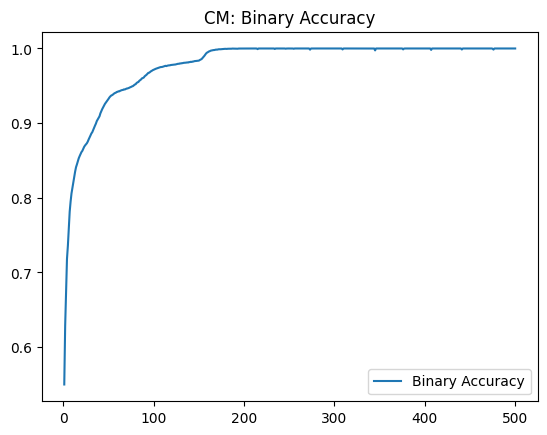

In [73]:
plot_history(history, name='CM')

In [30]:
# Modifie input for unit models
x_train = gen_pair_inputs(x_train)

In [77]:
# First model that we are testing
# Chose whether or not to use biases
def create_model_1(plot_model=False, model_name='model1'):
    # Create the inputs
    inputs = gen_unit_inputs(len(x_train))

    # Create the units
    x = layers.concatenate(gen_units(inputs, 2, activation='relu', use_biases=True))
    
    # Add dense layers
    x = layers.Dense(64, activation='relu', use_bias=True, name='hidden_dense_1')(x)

    # Ouput layer
    outputs = layers.Dense(S, activation='sigmoid', use_bias=True, name='ouput')(x)

    model = keras.Model(
        inputs=inputs,
        outputs=outputs
    )
    
    # Plot the model if specified
    if plot_model:
        keras.utils.plot_model(
            model,
            show_shapes=True,
            show_layer_names=True,
            show_layer_activations=True,
            to_file=f'{model_name}.png',
        )
    
    # Return the model
    return model

In [78]:
# Create first model
model1 = create_model_1(plot_model=True)

# Compile and train the moded
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
METRICS = ['binary_accuracy']

EPOCHS = 1000
BATCH_SIZE = 512

model1.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS,
)


history = model1.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

## Batch size 512 with dense layer at 64: converges to aroud 0.833

Epoch 1/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step - binary_accuracy: 0.5164 - loss: 0.6935
Epoch 2/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - binary_accuracy: 0.5662 - loss: 0.6786
Epoch 3/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - binary_accuracy: 0.5996 - loss: 0.6543
Epoch 4/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - binary_accuracy: 0.6155 - loss: 0.6322
Epoch 5/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - binary_accuracy: 0.6352 - loss: 0.6089
Epoch 6/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - binary_accuracy: 0.6505 - loss: 0.5877
Epoch 7/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - binary_accuracy: 0.6625 - loss: 0.5694
Epoch 8/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - binary_accuracy: 0.6692 - loss: 0.5551
Epoch 9/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - binary_accuracy: 0.6761 - loss: 0.5440
Epoch 10/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - binary_accuracy: 0.6810 - loss: 0.5349
Epoch 11/1000
128/128 ━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - binary_accuracy: 0.8425 - loss: 0.2814
Epoch 125/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - binary_accuracy: 0.8409 - loss: 0.2836
Epoch 126/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - binary_accuracy: 0.8426 - loss: 0.2812
Epoch 127/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - binary_accuracy: 0.8424 - loss: 0.2803
Epoch 128/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - binary_accuracy: 0.8424 - loss: 0.2822
Epoch 129/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - binary_accuracy: 0.8409 - loss: 0.2822
Epoch 130/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - binary_accuracy: 0.8424 - loss: 0.2811
Epoch 131/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - binary_accuracy: 0.8419 - loss: 0.2813
Epoch 132/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - binary_accuracy: 0.8417 - loss: 0.2813
Epoch 133/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - binary_accuracy: 0.8420 - loss: 0.2809
Epoch 134/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - binary_accuracy: 0.8454 - loss: 0.2685
Epoch 247/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - binary_accuracy: 0.8442 - loss: 0.2700
Epoch 248/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - binary_accuracy: 0.8445 - loss: 0.2695
Epoch 249/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - binary_accuracy: 0.8458 - loss: 0.2681
Epoch 250/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - binary_accuracy: 0.8455 - loss: 0.2688
Epoch 251/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - binary_accuracy: 0.8442 - loss: 0.2694
Epoch 252/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - binary_accuracy: 0.8455 - loss: 0.2692
Epoch 253/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - binary_accuracy: 0.8447 - loss: 0.2691
Epoch 254/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - binary_accuracy: 0.8458 - loss: 0.2685
Epoch 255/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - binary_accuracy: 0.8450 - loss: 0.2686
Epoch 256/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - binary_accuracy: 0.8454 - loss: 0.2662
Epoch 369/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - binary_accuracy: 0.8459 - loss: 0.2665
Epoch 370/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - binary_accuracy: 0.8459 - loss: 0.2657
Epoch 371/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - binary_accuracy: 0.8456 - loss: 0.2666
Epoch 372/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - binary_accuracy: 0.8446 - loss: 0.2668
Epoch 373/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - binary_accuracy: 0.8460 - loss: 0.2655
Epoch 374/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - binary_accuracy: 0.8461 - loss: 0.2661
Epoch 375/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - binary_accuracy: 0.8459 - loss: 0.2660
Epoch 376/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - binary_accuracy: 0.8451 - loss: 0.2666
Epoch 377/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - binary_accuracy: 0.8452 - loss: 0.2661
Epoch 378/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - binary_accuracy: 0.8464 - loss: 0.2639
Epoch 491/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - binary_accuracy: 0.8468 - loss: 0.2642
Epoch 492/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - binary_accuracy: 0.8470 - loss: 0.2633
Epoch 493/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - binary_accuracy: 0.8478 - loss: 0.2629
Epoch 494/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - binary_accuracy: 0.8462 - loss: 0.2651
Epoch 495/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - binary_accuracy: 0.8472 - loss: 0.2635
Epoch 496/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - binary_accuracy: 0.8465 - loss: 0.2644
Epoch 497/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - binary_accuracy: 0.8471 - loss: 0.2639
Epoch 498/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - binary_accuracy: 0.8464 - loss: 0.2649
Epoch 499/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - binary_accuracy: 0.8480 - loss: 0.2637
Epoch 500/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - binary_accuracy: 0.8478 - loss: 0.2627
Epoch 613/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - binary_accuracy: 0.8477 - loss: 0.2622
Epoch 614/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - binary_accuracy: 0.8473 - loss: 0.2633
Epoch 615/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - binary_accuracy: 0.8488 - loss: 0.2622
Epoch 616/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - binary_accuracy: 0.8477 - loss: 0.2625
Epoch 617/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - binary_accuracy: 0.8470 - loss: 0.2629
Epoch 618/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - binary_accuracy: 0.8470 - loss: 0.2631
Epoch 619/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - binary_accuracy: 0.8474 - loss: 0.2628
Epoch 620/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - binary_accuracy: 0.8473 - loss: 0.2624
Epoch 621/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - binary_accuracy: 0.8470 - loss: 0.2630
Epoch 622/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - binary_accuracy: 0.8460 - loss: 0.2630
Epoch 735/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - binary_accuracy: 0.8485 - loss: 0.2620
Epoch 736/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - binary_accuracy: 0.8473 - loss: 0.2626
Epoch 737/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - binary_accuracy: 0.8462 - loss: 0.2631
Epoch 738/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - binary_accuracy: 0.8480 - loss: 0.2622
Epoch 739/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - binary_accuracy: 0.8459 - loss: 0.2628
Epoch 740/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - binary_accuracy: 0.8484 - loss: 0.2617
Epoch 741/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - binary_accuracy: 0.8482 - loss: 0.2615
Epoch 742/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - binary_accuracy: 0.8474 - loss: 0.2621
Epoch 743/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - binary_accuracy: 0.8476 - loss: 0.2618
Epoch 744/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - binary_accuracy: 0.8482 - loss: 0.2616
Epoch 857/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - binary_accuracy: 0.8474 - loss: 0.2619
Epoch 858/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - binary_accuracy: 0.8477 - loss: 0.2616
Epoch 859/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - binary_accuracy: 0.8474 - loss: 0.2622
Epoch 860/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - binary_accuracy: 0.8466 - loss: 0.2626
Epoch 861/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - binary_accuracy: 0.8474 - loss: 0.2623
Epoch 862/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - binary_accuracy: 0.8472 - loss: 0.2620
Epoch 863/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - binary_accuracy: 0.8473 - loss: 0.2618
Epoch 864/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - binary_accuracy: 0.8457 - loss: 0.2632
Epoch 865/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - binary_accuracy: 0.8480 - loss: 0.2610
Epoch 866/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - binary_accuracy: 0.8472 - loss: 0.2619
Epoch 979/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - binary_accuracy: 0.8480 - loss: 0.2612
Epoch 980/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - binary_accuracy: 0.8467 - loss: 0.2619
Epoch 981/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - binary_accuracy: 0.8477 - loss: 0.2615
Epoch 982/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - binary_accuracy: 0.8475 - loss: 0.2613
Epoch 983/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - binary_accuracy: 0.8483 - loss: 0.2611
Epoch 984/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - binary_accuracy: 0.8474 - loss: 0.2621
Epoch 985/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - binary_accuracy: 0.8480 - loss: 0.2613
Epoch 986/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - binary_accuracy: 0.8470 - loss: 0.2617
Epoch 987/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - binary_accuracy: 0.8478 - loss: 0.2611
Epoch 988/1000
128/128 ━━

1721


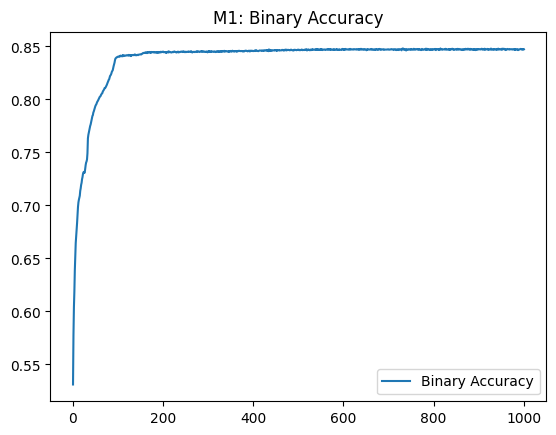

In [79]:
print(model1.count_params())
plot_history(history, 'M1')

In [80]:
# Second model: does an extra unit reduction
## Doesn't actually change much although
## some obtained results are extremely performant
def create_model_2(hidden_dense_1_size=256, plot_model=False, model_name='model2'):
    # Create the input units
    inputs = gen_unit_inputs(len(x_train))
    
    # Create the units on the inputs
    x = gen_units(inputs, size=2, activation='relu')
    
    # Unit reduction to size 3
    x = layers.concatenate(reduce_units(x, size=3, activation='relu'))
    
    # Hidden dense layer
    x = layers.Dense(hidden_dense_1_size, activation='relu', name='hidden_dense_1')(x)
    
    # Output layer
    outputs = layers.Dense(S, activation='sigmoid', name='output')(x)
    
    # Create the model
    model = keras.Model(inputs=inputs,
                        outputs=outputs)
    
    # Plot the model if specified
    if plot_model:
        keras.utils.plot_model(
            model,
            show_shapes=True,
            show_layer_names=True,
            show_layer_activations=True,
            to_file=f'{model_name}.png',
        )
    
    # Return the model
    return model

In [81]:
## Take results with a pinch of salt, can be very variable
## Train gets more gradual the lower the size
## Ran on 512 epochs
## Sizes with error: 16 (0.6984), 32 (0.8699), 64 (0.8585), 128 (0.8697), 256 (0.8330), 512 (0.80), 1024 (0.8673)
model2 = create_model_2(hidden_dense_1_size=128, plot_model=True)

OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
METRICS = ['binary_accuracy']

EPOCHS = 500
BATCH_SIZE = 512 
## Doesn't change convergence much deteriorates after 512. 
## Curve gets a lot steeper with higher batch size.
## Makes sense as then epoch size needs to increase for
## to reach convergence
## Huge impact on speed

model2.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS,
)

history = model2.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
)

Epoch 1/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - binary_accuracy: 0.5327 - loss: 0.6871
Epoch 2/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - binary_accuracy: 0.5899 - loss: 0.6410
Epoch 3/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - binary_accuracy: 0.6211 - loss: 0.6006
Epoch 4/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - binary_accuracy: 0.6668 - loss: 0.5464
Epoch 5/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - binary_accuracy: 0.6977 - loss: 0.5026
Epoch 6/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - binary_accuracy: 0.7140 - loss: 0.4781
Epoch 7/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - binary_accuracy: 0.7318 - loss: 0.4552
Epoch 8/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - binary_accuracy: 0.7485 - loss: 0.4329
Epoch 9/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - binary_accuracy: 0.7579 - loss: 0.4162
Epoch 10/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - binary_accuracy: 0.7736 - loss: 0.3963
Epoch 11/500
128/128 ━━━━━━━━━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - binary_accuracy: 0.9498 - loss: 0.0921
Epoch 126/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - binary_accuracy: 0.9499 - loss: 0.0918
Epoch 127/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - binary_accuracy: 0.9500 - loss: 0.0914
Epoch 128/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - binary_accuracy: 0.9508 - loss: 0.0910
Epoch 129/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - binary_accuracy: 0.9500 - loss: 0.0909
Epoch 130/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - binary_accuracy: 0.9502 - loss: 0.0909
Epoch 131/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - binary_accuracy: 0.9510 - loss: 0.0898
Epoch 132/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - binary_accuracy: 0.9510 - loss: 0.0903
Epoch 133/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - binary_accuracy: 0.9517 - loss: 0.0891
Epoch 134/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - binary_accuracy: 0.9517 - loss: 0.0892
Epoch 135/500
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - binary_accuracy: 0.9788 - loss: 0.0542
Epoch 250/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - binary_accuracy: 0.9787 - loss: 0.0538
Epoch 251/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - binary_accuracy: 0.9794 - loss: 0.0534
Epoch 252/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - binary_accuracy: 0.9792 - loss: 0.0532
Epoch 253/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - binary_accuracy: 0.9794 - loss: 0.0528
Epoch 254/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - binary_accuracy: 0.9790 - loss: 0.0531
Epoch 255/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - binary_accuracy: 0.9798 - loss: 0.0525
Epoch 256/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - binary_accuracy: 0.9799 - loss: 0.0521
Epoch 257/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - binary_accuracy: 0.9797 - loss: 0.0521
Epoch 258/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - binary_accuracy: 0.9796 - loss: 0.0519
Epoch 259/500
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - binary_accuracy: 0.9893 - loss: 0.0321
Epoch 374/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - binary_accuracy: 0.9896 - loss: 0.0318
Epoch 375/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - binary_accuracy: 0.9897 - loss: 0.0316
Epoch 376/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - binary_accuracy: 0.9894 - loss: 0.0320
Epoch 377/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - binary_accuracy: 0.9897 - loss: 0.0317
Epoch 378/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - binary_accuracy: 0.9898 - loss: 0.0316
Epoch 379/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - binary_accuracy: 0.9893 - loss: 0.0318
Epoch 380/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - binary_accuracy: 0.9899 - loss: 0.0315
Epoch 381/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - binary_accuracy: 0.9894 - loss: 0.0316
Epoch 382/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - binary_accuracy: 0.9896 - loss: 0.0315
Epoch 383/500
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - binary_accuracy: 0.9936 - loss: 0.0208
Epoch 498/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - binary_accuracy: 0.9940 - loss: 0.0203
Epoch 499/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - binary_accuracy: 0.9942 - loss: 0.0200
Epoch 500/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - binary_accuracy: 0.9940 - loss: 0.0203


2933


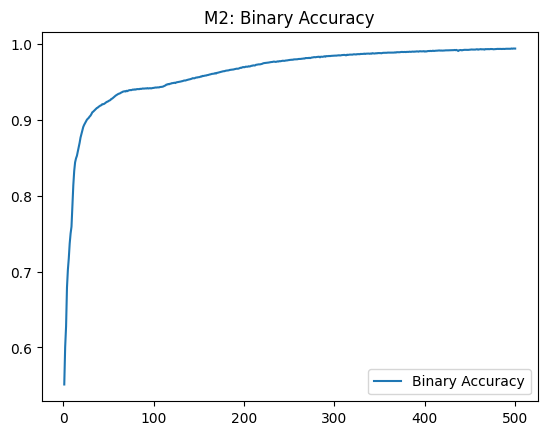

In [82]:
print(model2.count_params())
plot_history(history, 'M2')

In [32]:
# Model that uses 3 unit layers

## Over 1000 epochs without the dense layer,
## performance does not improve significantly
## meaning convergence around 0.65

## Changing batch size has similar results

## Dense layer 64: 0.7305 at 500 epochs
## Dense layer 128: 0.8072 at 500 epochs

## Size of units: 5, 5, 5, dense layer 128: 0.9508 at 500 epochs
## Size of units: 5, 5, 5, no dense layer: 0.8346 at 500 epochs 
## Units: 2, 5, 7: no dense layer: 0.7973 at 500 epochs
## Units: 3, 7, 7, no dense: 0.8964 at 500 epochs
## Units: 7, 5, 3, no dense: 0.7638 at 500 epochs
## Units: 4, 8, 8, no dense: 0.8639 at 500 epochs
## Units: 4, 8, 16, no dense: 0.8984 at 500 epochs
## Units: 8, 8, 8, no dense: 0.8927 at 500 epochs
## Units: 3, 7, 7, dense 32: 1 at 130 epochs
## Units: 2, 6, 6, dense 32: 0.8696 at 500 epochs
## Units: 2, 7, 6, dense 32: 0.7589 at 500 epochs
## Units: 3, 6, 6, dense 32: 0.8742 at 500 epochs
## Units: 3, 7, 8, dense 32: 0.9940 at 500 epochs
## Units: 4, 8, 8, dense 16: 0.9452 at 500 epochs
## Units: 4, 10, 10, dense 10: 0.8993 at 500 epochs
## Units: 5, 9, 9, dense 10: 0.9308 at 500 epochs
## Units: 4, 6, 6, dense 16: 0.9033 at 500 epochs
## Units: 4, 4, 4, dense 32: 0.9075 at 500 epochs
## Units: 8, 8, 8, dense 16: 0.9068 at 500 epochs
## Units: 3, 7, 8, dense 16: 0.9008 at 500 epochs
## Units: 4, 6, 6, dense 16: 0.8825 at 500 epochs
## Units: 3, 8, 6, dense 32: 0.8660 at 500 epochs
## Units: 4, 6, 6, dense 32: 0.8818 at 500 epochs
## Units: 10, 10, 10, densee 16: 0.9694 at 500 epochs
## Units: 4, 8, 8 dense 32: 1 at 190 epochs
## Units: 4, 8, 8 dense 28: 1 at 180 epochs
## Units: 4, 7, 7 dense 28: 1 at 500 epochs
## Units: 4, 7, 7 dense 24: 0.9423 at 500 epochs
## Units: 4, 8, 8 dense 24: 1 at 450 epochs
## Units: 4, 8, 8, dense 20: 0.9916 at 500 epochs
## Untis: 4, 8, 8, dense 16: 0.9489 at 500 epochs
## Units: 4, 8, 8, dense 12: 0.9349 at 500 epochs
## Units: 4, 8, 8, dense 8: 0.8396 at 500 epochs
## Units: 4, 8, 8, dense 10: 0.9202 at 500 epochs
## Units: 4, 8, 8, dense 8: 0.8831 at 1000 epochs gonna be hard to get better with this layer config
## Units: 4, 8, 8, dense 10: 0.9534 at 10000 epochs
## Units: 16, 16, 16, no dense: 0.9004 at 500 epochs
## Units: 16, 8, 4, no dense: 0.7853 at 500 epochs

def create_model_3(plot_model=False, model_name='model3'):
    inputs = gen_unit_inputs(len(x_train))
    
    # Here are the three unit reduction layers
    x = gen_units(inputs, size=4, activation='relu')
    x = reduce_units(x, size=8, activation='relu', unit_name='first_reducer_unit')
    x = layers.concatenate(reduce_units(x, size=8, activation='relu', unit_name='second_reducer_unit'))
    
    # Dense layer
    x = layers.Dense(10, activation='relu', name='post_reduction_dense')(x)
    
    # Outputs
    outputs = layers.Dense(S, activation='sigmoid', name='outputs')(x)
    
    model = keras.Model(
        inputs=inputs,
        outputs=outputs
    )
    
    if plot_model:
        keras.utils.plot_model(
            model,
            show_shapes=True,
            show_layer_names=True,
            show_layer_activations=True,
            to_file=f'{model_name}.png',
        )
    
    return model

In [19]:
# Create the third model
model3 = create_model_3(plot_model=True)

# Define model parameters
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
METRICS = ['binary_accuracy']

EPOCHS = 500
BATCH_SIZE = 512

model3.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS,
)

history = model3.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
)

Epoch 1/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - binary_accuracy: 0.5185 - loss: 0.6913
Epoch 2/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.5806 - loss: 0.6697
Epoch 3/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6365 - loss: 0.6143
Epoch 4/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6712 - loss: 0.5482
Epoch 5/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6873 - loss: 0.5118
Epoch 6/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7011 - loss: 0.4952
Epoch 7/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7063 - loss: 0.4859
Epoch 8/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7158 - loss: 0.4794
Epoch 9/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7137 - loss: 0.4754
Epoch 10/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7126 - loss: 0.4711
Epoch 11/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - bin

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7468 - loss: 0.3869
Epoch 128/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7466 - loss: 0.3860
Epoch 129/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7453 - loss: 0.3866
Epoch 130/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7458 - loss: 0.3861
Epoch 131/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7465 - loss: 0.3855
Epoch 132/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7482 - loss: 0.3866
Epoch 133/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7478 - loss: 0.3858
Epoch 134/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7483 - loss: 0.3854
Epoch 135/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7486 - loss: 0.3851
Epoch 136/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7498 - loss: 0.3848
Epoch 137/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7722 - loss: 0.3618
Epoch 254/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7702 - loss: 0.3629
Epoch 255/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7713 - loss: 0.3615
Epoch 256/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7720 - loss: 0.3613
Epoch 257/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7702 - loss: 0.3622
Epoch 258/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7710 - loss: 0.3619
Epoch 259/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7704 - loss: 0.3617
Epoch 260/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7713 - loss: 0.3619
Epoch 261/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7707 - loss: 0.3608
Epoch 262/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7720 - loss: 0.3624
Epoch 263/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7841 - loss: 0.3458
Epoch 380/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7847 - loss: 0.3447
Epoch 381/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7862 - loss: 0.3450
Epoch 382/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7863 - loss: 0.3449
Epoch 383/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7846 - loss: 0.3457
Epoch 384/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7854 - loss: 0.3456
Epoch 385/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7855 - loss: 0.3456
Epoch 386/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7859 - loss: 0.3456
Epoch 387/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7841 - loss: 0.3457
Epoch 388/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7866 - loss: 0.3448
Epoch 389/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

1657


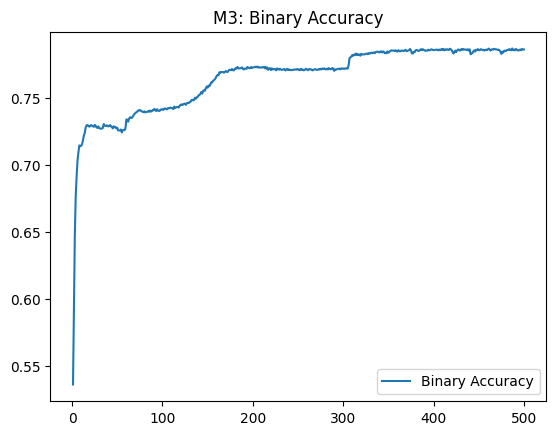

In [20]:
print(model3.count_params())
plot_history(history, 'M3')

In [21]:
# This section is to generate some graphs to include in the paper

# Funciton to save the history
def save_history(name):
    plt.savefig(f'{name}.png', bbox_inches='tight')

In [37]:
# Sample output for classic model
model = create_model_3()

# Define some parameters
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
METRICS = ['binary_accuracy']

EPOCHS = 10000
BATCH_SIZE = 512

# Compile the model
model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS,
)

# Train the model
history = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
)

Epoch 1/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - binary_accuracy: 0.5224 - loss: 0.6914
Epoch 2/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.5646 - loss: 0.6676
Epoch 3/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6132 - loss: 0.6114
Epoch 4/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6446 - loss: 0.5796
Epoch 5/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6702 - loss: 0.5530
Epoch 6/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7011 - loss: 0.5199
Epoch 7/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7241 - loss: 0.4824
Epoch 8/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7333 - loss: 0.4566
Epoch 9/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7352 - loss: 0.4429
Epoch 10/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7409 - loss: 0.4324
Epoch 11/10000
128/128 ━━━━━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7655 - loss: 0.3823
Epoch 64/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7659 - loss: 0.3822
Epoch 65/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7660 - loss: 0.3821
Epoch 66/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7672 - loss: 0.3810
Epoch 67/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7667 - loss: 0.3821
Epoch 68/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7680 - loss: 0.3811
Epoch 69/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7666 - loss: 0.3812
Epoch 70/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7682 - loss: 0.3808
Epoch 71/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7688 - loss: 0.3803
Epoch 72/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7684 - loss: 0.3803
Epoch 73/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7727 - loss: 0.3733
Epoch 126/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7737 - loss: 0.3731
Epoch 127/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7706 - loss: 0.3746
Epoch 128/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7724 - loss: 0.3732
Epoch 129/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7737 - loss: 0.3724
Epoch 130/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7729 - loss: 0.3725
Epoch 131/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7729 - loss: 0.3722
Epoch 132/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7738 - loss: 0.3717
Epoch 133/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7734 - loss: 0.3712
Epoch 134/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7740 - loss: 0.3705
Epoch 135/10000
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7941 - loss: 0.3424
Epoch 188/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7921 - loss: 0.3437
Epoch 189/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7925 - loss: 0.3435
Epoch 190/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7922 - loss: 0.3431
Epoch 191/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7927 - loss: 0.3435
Epoch 192/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7919 - loss: 0.3434
Epoch 193/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7946 - loss: 0.3414
Epoch 194/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7922 - loss: 0.3422
Epoch 195/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7933 - loss: 0.3423
Epoch 196/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7927 - loss: 0.3435
Epoch 197/10000
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7934 - loss: 0.3407
Epoch 250/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7940 - loss: 0.3413
Epoch 251/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7935 - loss: 0.3412
Epoch 252/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7931 - loss: 0.3406
Epoch 253/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7940 - loss: 0.3398
Epoch 254/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7941 - loss: 0.3402
Epoch 255/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7930 - loss: 0.3417
Epoch 256/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7942 - loss: 0.3399
Epoch 257/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7929 - loss: 0.3402
Epoch 258/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7940 - loss: 0.3401
Epoch 259/10000
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7936 - loss: 0.3401
Epoch 312/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7930 - loss: 0.3401
Epoch 313/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7950 - loss: 0.3389
Epoch 314/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7949 - loss: 0.3392
Epoch 315/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7927 - loss: 0.3410
Epoch 316/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7937 - loss: 0.3399
Epoch 317/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7932 - loss: 0.3399
Epoch 318/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7937 - loss: 0.3390
Epoch 319/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7940 - loss: 0.3403
Epoch 320/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7938 - loss: 0.3396
Epoch 321/10000
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7940 - loss: 0.3394
Epoch 374/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7939 - loss: 0.3394
Epoch 375/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7941 - loss: 0.3397
Epoch 376/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7944 - loss: 0.3396
Epoch 377/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7950 - loss: 0.3392
Epoch 378/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7942 - loss: 0.3389
Epoch 379/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7938 - loss: 0.3399
Epoch 380/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7935 - loss: 0.3400
Epoch 381/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7940 - loss: 0.3396
Epoch 382/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7943 - loss: 0.3392
Epoch 383/10000
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7943 - loss: 0.3390
Epoch 436/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7942 - loss: 0.3392
Epoch 437/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7942 - loss: 0.3396
Epoch 438/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7945 - loss: 0.3392
Epoch 439/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7939 - loss: 0.3394
Epoch 440/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7938 - loss: 0.3403
Epoch 441/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7939 - loss: 0.3397
Epoch 442/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7939 - loss: 0.3394
Epoch 443/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7948 - loss: 0.3393
Epoch 444/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7949 - loss: 0.3387
Epoch 445/10000
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7951 - loss: 0.3387
Epoch 498/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7959 - loss: 0.3380
Epoch 499/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7941 - loss: 0.3400
Epoch 500/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7949 - loss: 0.3401
Epoch 501/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7940 - loss: 0.3396
Epoch 502/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7929 - loss: 0.3399
Epoch 503/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7952 - loss: 0.3391
Epoch 504/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7935 - loss: 0.3400
Epoch 505/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7948 - loss: 0.3396
Epoch 506/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7949 - loss: 0.3395
Epoch 507/10000
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7942 - loss: 0.3402
Epoch 560/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7959 - loss: 0.3383
Epoch 561/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7942 - loss: 0.3388
Epoch 562/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7953 - loss: 0.3390
Epoch 563/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7935 - loss: 0.3405
Epoch 564/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7945 - loss: 0.3397
Epoch 565/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7969 - loss: 0.3378
Epoch 566/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7938 - loss: 0.3400
Epoch 567/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7939 - loss: 0.3392
Epoch 568/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7960 - loss: 0.3380
Epoch 569/10000
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7959 - loss: 0.3375
Epoch 622/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7946 - loss: 0.3389
Epoch 623/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7945 - loss: 0.3391
Epoch 624/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7939 - loss: 0.3390
Epoch 625/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7953 - loss: 0.3386
Epoch 626/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7965 - loss: 0.3378
Epoch 627/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7958 - loss: 0.3383
Epoch 628/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7950 - loss: 0.3388
Epoch 629/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7955 - loss: 0.3388
Epoch 630/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7952 - loss: 0.3389
Epoch 631/10000
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7959 - loss: 0.3376
Epoch 684/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7958 - loss: 0.3381
Epoch 685/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7955 - loss: 0.3381
Epoch 686/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7955 - loss: 0.3387
Epoch 687/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7959 - loss: 0.3384
Epoch 688/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7962 - loss: 0.3372
Epoch 689/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7959 - loss: 0.3378
Epoch 690/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7957 - loss: 0.3387
Epoch 691/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7957 - loss: 0.3385
Epoch 692/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7962 - loss: 0.3391
Epoch 693/10000
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7963 - loss: 0.3385
Epoch 746/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7975 - loss: 0.3375
Epoch 747/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7969 - loss: 0.3374
Epoch 748/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7962 - loss: 0.3379
Epoch 749/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7965 - loss: 0.3383
Epoch 750/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7966 - loss: 0.3376
Epoch 751/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7963 - loss: 0.3375
Epoch 752/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7968 - loss: 0.3371
Epoch 753/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7950 - loss: 0.3383
Epoch 754/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7958 - loss: 0.3381
Epoch 755/10000
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7954 - loss: 0.3377
Epoch 808/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7965 - loss: 0.3381
Epoch 809/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7952 - loss: 0.3389
Epoch 810/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7956 - loss: 0.3384
Epoch 811/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7966 - loss: 0.3376
Epoch 812/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7952 - loss: 0.3382
Epoch 813/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7970 - loss: 0.3371
Epoch 814/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7967 - loss: 0.3377
Epoch 815/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7962 - loss: 0.3381
Epoch 816/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7975 - loss: 0.3379
Epoch 817/10000
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7964 - loss: 0.3383
Epoch 870/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7960 - loss: 0.3380
Epoch 871/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7968 - loss: 0.3381
Epoch 872/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7966 - loss: 0.3378
Epoch 873/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7967 - loss: 0.3375
Epoch 874/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7973 - loss: 0.3375
Epoch 875/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7959 - loss: 0.3381
Epoch 876/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7959 - loss: 0.3384
Epoch 877/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7963 - loss: 0.3382
Epoch 878/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7971 - loss: 0.3375
Epoch 879/10000
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7978 - loss: 0.3376
Epoch 932/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7961 - loss: 0.3384
Epoch 933/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7970 - loss: 0.3375
Epoch 934/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7967 - loss: 0.3372
Epoch 935/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7973 - loss: 0.3372
Epoch 936/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7956 - loss: 0.3374
Epoch 937/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7965 - loss: 0.3382
Epoch 938/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7980 - loss: 0.3366
Epoch 939/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7976 - loss: 0.3365
Epoch 940/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7967 - loss: 0.3373
Epoch 941/10000
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7966 - loss: 0.3378
Epoch 994/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7959 - loss: 0.3381
Epoch 995/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7965 - loss: 0.3380
Epoch 996/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7965 - loss: 0.3391
Epoch 997/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7953 - loss: 0.3384
Epoch 998/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7968 - loss: 0.3378
Epoch 999/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7968 - loss: 0.3367
Epoch 1000/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7979 - loss: 0.3366
Epoch 1001/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7979 - loss: 0.3371
Epoch 1002/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7974 - loss: 0.3369
Epoch 1003/10000
128/128 ━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7972 - loss: 0.3376
Epoch 1055/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7984 - loss: 0.3365
Epoch 1056/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7989 - loss: 0.3361
Epoch 1057/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7989 - loss: 0.3364
Epoch 1058/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7961 - loss: 0.3379
Epoch 1059/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7962 - loss: 0.3379
Epoch 1060/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7988 - loss: 0.3360
Epoch 1061/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7972 - loss: 0.3370
Epoch 1062/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7953 - loss: 0.3380
Epoch 1063/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7970 - loss: 0.3371
Epoch 1064/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7978 - loss: 0.3364
Epoch 1116/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7988 - loss: 0.3369
Epoch 1117/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7989 - loss: 0.3369
Epoch 1118/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7982 - loss: 0.3373
Epoch 1119/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7976 - loss: 0.3368
Epoch 1120/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7972 - loss: 0.3369
Epoch 1121/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7973 - loss: 0.3373
Epoch 1122/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7976 - loss: 0.3368
Epoch 1123/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7970 - loss: 0.3363
Epoch 1124/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7970 - loss: 0.3374
Epoch 1125/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7979 - loss: 0.3371
Epoch 1177/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7977 - loss: 0.3385
Epoch 1178/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7984 - loss: 0.3368
Epoch 1179/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7975 - loss: 0.3368
Epoch 1180/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7967 - loss: 0.3383
Epoch 1181/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7984 - loss: 0.3372
Epoch 1182/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7970 - loss: 0.3379
Epoch 1183/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7974 - loss: 0.3368
Epoch 1184/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7967 - loss: 0.3382
Epoch 1185/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7980 - loss: 0.3370
Epoch 1186/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7987 - loss: 0.3363
Epoch 1238/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7989 - loss: 0.3361
Epoch 1239/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7970 - loss: 0.3375
Epoch 1240/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7979 - loss: 0.3373
Epoch 1241/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7976 - loss: 0.3376
Epoch 1242/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7991 - loss: 0.3367
Epoch 1243/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7992 - loss: 0.3357
Epoch 1244/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7966 - loss: 0.3372
Epoch 1245/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7979 - loss: 0.3371
Epoch 1246/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7982 - loss: 0.3371
Epoch 1247/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7986 - loss: 0.3371
Epoch 1299/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7989 - loss: 0.3367
Epoch 1300/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7985 - loss: 0.3366
Epoch 1301/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7976 - loss: 0.3378
Epoch 1302/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7978 - loss: 0.3378
Epoch 1303/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7984 - loss: 0.3365
Epoch 1304/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7977 - loss: 0.3363
Epoch 1305/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7984 - loss: 0.3363
Epoch 1306/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7974 - loss: 0.3370
Epoch 1307/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7990 - loss: 0.3365
Epoch 1308/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7982 - loss: 0.3365
Epoch 1360/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7986 - loss: 0.3368
Epoch 1361/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7997 - loss: 0.3358
Epoch 1362/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7983 - loss: 0.3369
Epoch 1363/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7977 - loss: 0.3372
Epoch 1364/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7987 - loss: 0.3368
Epoch 1365/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7984 - loss: 0.3369
Epoch 1366/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7987 - loss: 0.3365
Epoch 1367/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7971 - loss: 0.3372
Epoch 1368/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7984 - loss: 0.3362
Epoch 1369/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7990 - loss: 0.3364
Epoch 1421/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7991 - loss: 0.3365
Epoch 1422/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7979 - loss: 0.3369
Epoch 1423/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7986 - loss: 0.3366
Epoch 1424/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7991 - loss: 0.3367
Epoch 1425/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7989 - loss: 0.3358
Epoch 1426/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7991 - loss: 0.3360
Epoch 1427/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7972 - loss: 0.3372
Epoch 1428/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7977 - loss: 0.3373
Epoch 1429/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7992 - loss: 0.3363
Epoch 1430/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7973 - loss: 0.3377
Epoch 1482/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7990 - loss: 0.3362
Epoch 1483/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8009 - loss: 0.3353
Epoch 1484/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7987 - loss: 0.3365
Epoch 1485/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7999 - loss: 0.3357
Epoch 1486/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7993 - loss: 0.3364
Epoch 1487/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7988 - loss: 0.3359
Epoch 1488/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7980 - loss: 0.3375
Epoch 1489/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7992 - loss: 0.3362
Epoch 1490/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7996 - loss: 0.3361
Epoch 1491/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8022 - loss: 0.3350
Epoch 1543/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8018 - loss: 0.3353
Epoch 1544/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8015 - loss: 0.3347
Epoch 1545/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8024 - loss: 0.3343
Epoch 1546/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8015 - loss: 0.3357
Epoch 1547/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8019 - loss: 0.3350
Epoch 1548/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8026 - loss: 0.3350
Epoch 1549/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8013 - loss: 0.3352
Epoch 1550/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8017 - loss: 0.3350
Epoch 1551/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8023 - loss: 0.3361
Epoch 1552/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8043 - loss: 0.3319
Epoch 1604/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8037 - loss: 0.3329
Epoch 1605/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8026 - loss: 0.3330
Epoch 1606/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8040 - loss: 0.3326
Epoch 1607/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8034 - loss: 0.3326
Epoch 1608/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8033 - loss: 0.3330
Epoch 1609/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8047 - loss: 0.3311
Epoch 1610/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8036 - loss: 0.3322
Epoch 1611/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8036 - loss: 0.3326
Epoch 1612/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8044 - loss: 0.3321
Epoch 1613/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8077 - loss: 0.3261
Epoch 1665/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8068 - loss: 0.3263
Epoch 1666/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8061 - loss: 0.3270
Epoch 1667/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8081 - loss: 0.3257
Epoch 1668/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8079 - loss: 0.3251
Epoch 1669/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8075 - loss: 0.3246
Epoch 1670/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8074 - loss: 0.3262
Epoch 1671/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8070 - loss: 0.3240
Epoch 1672/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8082 - loss: 0.3239
Epoch 1673/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8082 - loss: 0.3234
Epoch 1674/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8121 - loss: 0.3188
Epoch 1726/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8101 - loss: 0.3186
Epoch 1727/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8115 - loss: 0.3183
Epoch 1728/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8105 - loss: 0.3180
Epoch 1729/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8106 - loss: 0.3181
Epoch 1730/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8111 - loss: 0.3190
Epoch 1731/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8102 - loss: 0.3174
Epoch 1732/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8125 - loss: 0.3177
Epoch 1733/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8105 - loss: 0.3174
Epoch 1734/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8107 - loss: 0.3179
Epoch 1735/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8138 - loss: 0.3153
Epoch 1787/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8128 - loss: 0.3156
Epoch 1788/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8127 - loss: 0.3166
Epoch 1789/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8129 - loss: 0.3167
Epoch 1790/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8129 - loss: 0.3163
Epoch 1791/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8134 - loss: 0.3150
Epoch 1792/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8114 - loss: 0.3168
Epoch 1793/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8122 - loss: 0.3164
Epoch 1794/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8123 - loss: 0.3163
Epoch 1795/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8121 - loss: 0.3168
Epoch 1796/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8148 - loss: 0.3158
Epoch 1848/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8134 - loss: 0.3155
Epoch 1849/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8139 - loss: 0.3154
Epoch 1850/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8137 - loss: 0.3157
Epoch 1851/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8146 - loss: 0.3154
Epoch 1852/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8144 - loss: 0.3151
Epoch 1853/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8141 - loss: 0.3157
Epoch 1854/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8149 - loss: 0.3153
Epoch 1855/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8144 - loss: 0.3154
Epoch 1856/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8150 - loss: 0.3150
Epoch 1857/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8136 - loss: 0.3160
Epoch 1909/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8157 - loss: 0.3143
Epoch 1910/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8162 - loss: 0.3147
Epoch 1911/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8150 - loss: 0.3140
Epoch 1912/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8144 - loss: 0.3153
Epoch 1913/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8175 - loss: 0.3145
Epoch 1914/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8163 - loss: 0.3145
Epoch 1915/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8142 - loss: 0.3149
Epoch 1916/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8152 - loss: 0.3151
Epoch 1917/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8150 - loss: 0.3151
Epoch 1918/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8160 - loss: 0.3147
Epoch 1970/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8174 - loss: 0.3137
Epoch 1971/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8165 - loss: 0.3141
Epoch 1972/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8170 - loss: 0.3145
Epoch 1973/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8172 - loss: 0.3135
Epoch 1974/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8186 - loss: 0.3133
Epoch 1975/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8165 - loss: 0.3141
Epoch 1976/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8171 - loss: 0.3146
Epoch 1977/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8187 - loss: 0.3141
Epoch 1978/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8177 - loss: 0.3139
Epoch 1979/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8187 - loss: 0.3147
Epoch 2031/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8180 - loss: 0.3132
Epoch 2032/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8184 - loss: 0.3133
Epoch 2033/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8196 - loss: 0.3132
Epoch 2034/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8185 - loss: 0.3144
Epoch 2035/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8187 - loss: 0.3131
Epoch 2036/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8191 - loss: 0.3146
Epoch 2037/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8204 - loss: 0.3138
Epoch 2038/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8220 - loss: 0.3121
Epoch 2039/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8198 - loss: 0.3142
Epoch 2040/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8430 - loss: 0.2962
Epoch 2092/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8429 - loss: 0.2960
Epoch 2093/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8433 - loss: 0.2957
Epoch 2094/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8432 - loss: 0.2951
Epoch 2095/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8442 - loss: 0.2948
Epoch 2096/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8446 - loss: 0.2931
Epoch 2097/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8439 - loss: 0.2937
Epoch 2098/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8439 - loss: 0.2934
Epoch 2099/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8449 - loss: 0.2939
Epoch 2100/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8442 - loss: 0.2931
Epoch 2101/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8535 - loss: 0.2810
Epoch 2153/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8527 - loss: 0.2812
Epoch 2154/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8534 - loss: 0.2813
Epoch 2155/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8543 - loss: 0.2798
Epoch 2156/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8550 - loss: 0.2795
Epoch 2157/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8530 - loss: 0.2803
Epoch 2158/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8539 - loss: 0.2800
Epoch 2159/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8538 - loss: 0.2806
Epoch 2160/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8542 - loss: 0.2798
Epoch 2161/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8541 - loss: 0.2798
Epoch 2162/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8556 - loss: 0.2753
Epoch 2214/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8551 - loss: 0.2759
Epoch 2215/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8562 - loss: 0.2754
Epoch 2216/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8554 - loss: 0.2754
Epoch 2217/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8545 - loss: 0.2770
Epoch 2218/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8553 - loss: 0.2754
Epoch 2219/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8551 - loss: 0.2754
Epoch 2220/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8541 - loss: 0.2764
Epoch 2221/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8557 - loss: 0.2756
Epoch 2222/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8570 - loss: 0.2741
Epoch 2223/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8551 - loss: 0.2738
Epoch 2275/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8564 - loss: 0.2733
Epoch 2276/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8569 - loss: 0.2737
Epoch 2277/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8549 - loss: 0.2737
Epoch 2278/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8562 - loss: 0.2727
Epoch 2279/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8563 - loss: 0.2733
Epoch 2280/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8570 - loss: 0.2723
Epoch 2281/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8564 - loss: 0.2724
Epoch 2282/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8563 - loss: 0.2738
Epoch 2283/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8557 - loss: 0.2742
Epoch 2284/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8565 - loss: 0.2725
Epoch 2336/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8561 - loss: 0.2727
Epoch 2337/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8564 - loss: 0.2730
Epoch 2338/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8566 - loss: 0.2718
Epoch 2339/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8563 - loss: 0.2731
Epoch 2340/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8561 - loss: 0.2723
Epoch 2341/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8569 - loss: 0.2716
Epoch 2342/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8551 - loss: 0.2734
Epoch 2343/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8571 - loss: 0.2713
Epoch 2344/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8549 - loss: 0.2737
Epoch 2345/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8562 - loss: 0.2722
Epoch 2397/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8566 - loss: 0.2714
Epoch 2398/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8575 - loss: 0.2711
Epoch 2399/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8574 - loss: 0.2716
Epoch 2400/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8578 - loss: 0.2708
Epoch 2401/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8570 - loss: 0.2716
Epoch 2402/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8572 - loss: 0.2711
Epoch 2403/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8565 - loss: 0.2723
Epoch 2404/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8567 - loss: 0.2723
Epoch 2405/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8564 - loss: 0.2724
Epoch 2406/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8567 - loss: 0.2725
Epoch 2458/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8573 - loss: 0.2710
Epoch 2459/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8584 - loss: 0.2706
Epoch 2460/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8566 - loss: 0.2715
Epoch 2461/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8565 - loss: 0.2721
Epoch 2462/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8575 - loss: 0.2713
Epoch 2463/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8566 - loss: 0.2722
Epoch 2464/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8573 - loss: 0.2707
Epoch 2465/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8578 - loss: 0.2710
Epoch 2466/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8589 - loss: 0.2699
Epoch 2467/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8575 - loss: 0.2713
Epoch 2519/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8589 - loss: 0.2706
Epoch 2520/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8585 - loss: 0.2707
Epoch 2521/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8580 - loss: 0.2704
Epoch 2522/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8579 - loss: 0.2699
Epoch 2523/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8591 - loss: 0.2696
Epoch 2524/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8581 - loss: 0.2701
Epoch 2525/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8570 - loss: 0.2717
Epoch 2526/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8576 - loss: 0.2703
Epoch 2527/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8577 - loss: 0.2711
Epoch 2528/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8584 - loss: 0.2697
Epoch 2580/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8580 - loss: 0.2712
Epoch 2581/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8602 - loss: 0.2680
Epoch 2582/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8565 - loss: 0.2710
Epoch 2583/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8592 - loss: 0.2700
Epoch 2584/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8577 - loss: 0.2709
Epoch 2585/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8589 - loss: 0.2700
Epoch 2586/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8589 - loss: 0.2693
Epoch 2587/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8577 - loss: 0.2700
Epoch 2588/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8587 - loss: 0.2709
Epoch 2589/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8573 - loss: 0.2709
Epoch 2641/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8586 - loss: 0.2700
Epoch 2642/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8589 - loss: 0.2696
Epoch 2643/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8588 - loss: 0.2704
Epoch 2644/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8601 - loss: 0.2686
Epoch 2645/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8589 - loss: 0.2690
Epoch 2646/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8585 - loss: 0.2701
Epoch 2647/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8593 - loss: 0.2698
Epoch 2648/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8590 - loss: 0.2692
Epoch 2649/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8586 - loss: 0.2687
Epoch 2650/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8586 - loss: 0.2701
Epoch 2702/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8584 - loss: 0.2693
Epoch 2703/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8590 - loss: 0.2697
Epoch 2704/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8584 - loss: 0.2697
Epoch 2705/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8578 - loss: 0.2703
Epoch 2706/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8595 - loss: 0.2694
Epoch 2707/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8587 - loss: 0.2695
Epoch 2708/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8593 - loss: 0.2692
Epoch 2709/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8584 - loss: 0.2702
Epoch 2710/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8594 - loss: 0.2686
Epoch 2711/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8589 - loss: 0.2697
Epoch 2763/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8588 - loss: 0.2690
Epoch 2764/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8597 - loss: 0.2690
Epoch 2765/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8582 - loss: 0.2701
Epoch 2766/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8590 - loss: 0.2697
Epoch 2767/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8598 - loss: 0.2683
Epoch 2768/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8588 - loss: 0.2693
Epoch 2769/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8585 - loss: 0.2705
Epoch 2770/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8574 - loss: 0.2706
Epoch 2771/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8590 - loss: 0.2692
Epoch 2772/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8590 - loss: 0.2692
Epoch 2824/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8582 - loss: 0.2694
Epoch 2825/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8589 - loss: 0.2695
Epoch 2826/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8601 - loss: 0.2681
Epoch 2827/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8591 - loss: 0.2695
Epoch 2828/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8585 - loss: 0.2700
Epoch 2829/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8590 - loss: 0.2697
Epoch 2830/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8595 - loss: 0.2691
Epoch 2831/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8595 - loss: 0.2683
Epoch 2832/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8591 - loss: 0.2697
Epoch 2833/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8602 - loss: 0.2686
Epoch 2885/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8595 - loss: 0.2700
Epoch 2886/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8593 - loss: 0.2690
Epoch 2887/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8605 - loss: 0.2677
Epoch 2888/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8592 - loss: 0.2698
Epoch 2889/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8595 - loss: 0.2698
Epoch 2890/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8590 - loss: 0.2702
Epoch 2891/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8585 - loss: 0.2698
Epoch 2892/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8592 - loss: 0.2693
Epoch 2893/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8603 - loss: 0.2684
Epoch 2894/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8594 - loss: 0.2692
Epoch 2946/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8591 - loss: 0.2689
Epoch 2947/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8594 - loss: 0.2696
Epoch 2948/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8599 - loss: 0.2689
Epoch 2949/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8591 - loss: 0.2693
Epoch 2950/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8609 - loss: 0.2678
Epoch 2951/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8589 - loss: 0.2702
Epoch 2952/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8579 - loss: 0.2702
Epoch 2953/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8589 - loss: 0.2695
Epoch 2954/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8599 - loss: 0.2680
Epoch 2955/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8603 - loss: 0.2687
Epoch 3007/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8603 - loss: 0.2688
Epoch 3008/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8592 - loss: 0.2691
Epoch 3009/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8596 - loss: 0.2686
Epoch 3010/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8597 - loss: 0.2689
Epoch 3011/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8605 - loss: 0.2686
Epoch 3012/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8593 - loss: 0.2689
Epoch 3013/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8594 - loss: 0.2704
Epoch 3014/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8596 - loss: 0.2684
Epoch 3015/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8594 - loss: 0.2685
Epoch 3016/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8608 - loss: 0.2682
Epoch 3068/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8603 - loss: 0.2681
Epoch 3069/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8603 - loss: 0.2681
Epoch 3070/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8598 - loss: 0.2694
Epoch 3071/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8592 - loss: 0.2698
Epoch 3072/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8604 - loss: 0.2684
Epoch 3073/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8592 - loss: 0.2696
Epoch 3074/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8599 - loss: 0.2683
Epoch 3075/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8606 - loss: 0.2679
Epoch 3076/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8601 - loss: 0.2686
Epoch 3077/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8599 - loss: 0.2686
Epoch 3129/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8599 - loss: 0.2691
Epoch 3130/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8596 - loss: 0.2688
Epoch 3131/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8598 - loss: 0.2696
Epoch 3132/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8612 - loss: 0.2679
Epoch 3133/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8609 - loss: 0.2682
Epoch 3134/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8604 - loss: 0.2683
Epoch 3135/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8599 - loss: 0.2687
Epoch 3136/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8603 - loss: 0.2681
Epoch 3137/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8615 - loss: 0.2671
Epoch 3138/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8600 - loss: 0.2689
Epoch 3190/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8602 - loss: 0.2682
Epoch 3191/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8602 - loss: 0.2685
Epoch 3192/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8602 - loss: 0.2685
Epoch 3193/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8602 - loss: 0.2692
Epoch 3194/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8604 - loss: 0.2685
Epoch 3195/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8593 - loss: 0.2692
Epoch 3196/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8604 - loss: 0.2685
Epoch 3197/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8592 - loss: 0.2686
Epoch 3198/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8587 - loss: 0.2696
Epoch 3199/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8602 - loss: 0.2685
Epoch 3251/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8601 - loss: 0.2682
Epoch 3252/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8606 - loss: 0.2677
Epoch 3253/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8597 - loss: 0.2689
Epoch 3254/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8602 - loss: 0.2686
Epoch 3255/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8589 - loss: 0.2693
Epoch 3256/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8597 - loss: 0.2680
Epoch 3257/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8604 - loss: 0.2681
Epoch 3258/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8597 - loss: 0.2691
Epoch 3259/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8602 - loss: 0.2690
Epoch 3260/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8607 - loss: 0.2679
Epoch 3312/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8613 - loss: 0.2677
Epoch 3313/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8589 - loss: 0.2692
Epoch 3314/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8608 - loss: 0.2678
Epoch 3315/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8599 - loss: 0.2693
Epoch 3316/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8598 - loss: 0.2688
Epoch 3317/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8601 - loss: 0.2683
Epoch 3318/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8597 - loss: 0.2685
Epoch 3319/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8612 - loss: 0.2663
Epoch 3320/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8615 - loss: 0.2671
Epoch 3321/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8596 - loss: 0.2686
Epoch 3373/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8600 - loss: 0.2680
Epoch 3374/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8606 - loss: 0.2681
Epoch 3375/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8604 - loss: 0.2680
Epoch 3376/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8617 - loss: 0.2666
Epoch 3377/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8620 - loss: 0.2671
Epoch 3378/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8599 - loss: 0.2688
Epoch 3379/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8598 - loss: 0.2686
Epoch 3380/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8609 - loss: 0.2685
Epoch 3381/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8602 - loss: 0.2685
Epoch 3382/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8611 - loss: 0.2682
Epoch 3434/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8608 - loss: 0.2681
Epoch 3435/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8599 - loss: 0.2682
Epoch 3436/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8609 - loss: 0.2677
Epoch 3437/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8616 - loss: 0.2676
Epoch 3438/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8613 - loss: 0.2669
Epoch 3439/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8596 - loss: 0.2681
Epoch 3440/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8604 - loss: 0.2679
Epoch 3441/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8607 - loss: 0.2690
Epoch 3442/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8608 - loss: 0.2679
Epoch 3443/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8610 - loss: 0.2672
Epoch 3495/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8597 - loss: 0.2684
Epoch 3496/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8617 - loss: 0.2672
Epoch 3497/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8611 - loss: 0.2680
Epoch 3498/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8614 - loss: 0.2674
Epoch 3499/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8625 - loss: 0.2670
Epoch 3500/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8623 - loss: 0.2665
Epoch 3501/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8608 - loss: 0.2685
Epoch 3502/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8626 - loss: 0.2666
Epoch 3503/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8610 - loss: 0.2668
Epoch 3504/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8616 - loss: 0.2672
Epoch 3556/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8600 - loss: 0.2680
Epoch 3557/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8598 - loss: 0.2688
Epoch 3558/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8615 - loss: 0.2675
Epoch 3559/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8617 - loss: 0.2674
Epoch 3560/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8621 - loss: 0.2671
Epoch 3561/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8608 - loss: 0.2678
Epoch 3562/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8618 - loss: 0.2672
Epoch 3563/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8616 - loss: 0.2673
Epoch 3564/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8611 - loss: 0.2666
Epoch 3565/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8614 - loss: 0.2668
Epoch 3617/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8626 - loss: 0.2658
Epoch 3618/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8618 - loss: 0.2674
Epoch 3619/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8612 - loss: 0.2674
Epoch 3620/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8605 - loss: 0.2681
Epoch 3621/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8607 - loss: 0.2678
Epoch 3622/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8610 - loss: 0.2667
Epoch 3623/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8617 - loss: 0.2666
Epoch 3624/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8611 - loss: 0.2671
Epoch 3625/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8606 - loss: 0.2683
Epoch 3626/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8615 - loss: 0.2667
Epoch 3678/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8609 - loss: 0.2676
Epoch 3679/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8611 - loss: 0.2673
Epoch 3680/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8607 - loss: 0.2671
Epoch 3681/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8614 - loss: 0.2668
Epoch 3682/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8611 - loss: 0.2674
Epoch 3683/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8613 - loss: 0.2674
Epoch 3684/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8617 - loss: 0.2673
Epoch 3685/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8628 - loss: 0.2660
Epoch 3686/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8610 - loss: 0.2676
Epoch 3687/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8615 - loss: 0.2674
Epoch 3739/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8633 - loss: 0.2653
Epoch 3740/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8616 - loss: 0.2669
Epoch 3741/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8617 - loss: 0.2669
Epoch 3742/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8613 - loss: 0.2681
Epoch 3743/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8628 - loss: 0.2660
Epoch 3744/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8620 - loss: 0.2659
Epoch 3745/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8624 - loss: 0.2661
Epoch 3746/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8609 - loss: 0.2671
Epoch 3747/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8627 - loss: 0.2660
Epoch 3748/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8625 - loss: 0.2658
Epoch 3800/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8621 - loss: 0.2664
Epoch 3801/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8628 - loss: 0.2652
Epoch 3802/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8616 - loss: 0.2677
Epoch 3803/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8616 - loss: 0.2657
Epoch 3804/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8619 - loss: 0.2665
Epoch 3805/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8612 - loss: 0.2671
Epoch 3806/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8630 - loss: 0.2656
Epoch 3807/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8623 - loss: 0.2661
Epoch 3808/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8627 - loss: 0.2654
Epoch 3809/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8608 - loss: 0.2676
Epoch 3861/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8633 - loss: 0.2649
Epoch 3862/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8622 - loss: 0.2662
Epoch 3863/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8611 - loss: 0.2670
Epoch 3864/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8629 - loss: 0.2657
Epoch 3865/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8627 - loss: 0.2664
Epoch 3866/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8622 - loss: 0.2666
Epoch 3867/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8627 - loss: 0.2660
Epoch 3868/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8614 - loss: 0.2664
Epoch 3869/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8629 - loss: 0.2652
Epoch 3870/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8642 - loss: 0.2631
Epoch 3922/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8644 - loss: 0.2630
Epoch 3923/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8644 - loss: 0.2630
Epoch 3924/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8649 - loss: 0.2615
Epoch 3925/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8634 - loss: 0.2630
Epoch 3926/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8655 - loss: 0.2616
Epoch 3927/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8652 - loss: 0.2623
Epoch 3928/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8644 - loss: 0.2621
Epoch 3929/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8639 - loss: 0.2621
Epoch 3930/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8650 - loss: 0.2618
Epoch 3931/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8692 - loss: 0.2558
Epoch 3983/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8694 - loss: 0.2562
Epoch 3984/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8672 - loss: 0.2588
Epoch 3985/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8685 - loss: 0.2567
Epoch 3986/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8691 - loss: 0.2567
Epoch 3987/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8680 - loss: 0.2563
Epoch 3988/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8690 - loss: 0.2556
Epoch 3989/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8685 - loss: 0.2556
Epoch 3990/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8693 - loss: 0.2556
Epoch 3991/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8698 - loss: 0.2557
Epoch 3992/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8724 - loss: 0.2516
Epoch 4044/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8713 - loss: 0.2522
Epoch 4045/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8722 - loss: 0.2521
Epoch 4046/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8723 - loss: 0.2506
Epoch 4047/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8719 - loss: 0.2517
Epoch 4048/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8714 - loss: 0.2527
Epoch 4049/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8712 - loss: 0.2523
Epoch 4050/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8723 - loss: 0.2512
Epoch 4051/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8722 - loss: 0.2518
Epoch 4052/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8730 - loss: 0.2512
Epoch 4053/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8728 - loss: 0.2496
Epoch 4105/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8730 - loss: 0.2500
Epoch 4106/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8730 - loss: 0.2494
Epoch 4107/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8728 - loss: 0.2496
Epoch 4108/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8727 - loss: 0.2494
Epoch 4109/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8733 - loss: 0.2491
Epoch 4110/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8734 - loss: 0.2487
Epoch 4111/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8736 - loss: 0.2493
Epoch 4112/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8731 - loss: 0.2497
Epoch 4113/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8740 - loss: 0.2486
Epoch 4114/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8739 - loss: 0.2479
Epoch 4166/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8734 - loss: 0.2476
Epoch 4167/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8730 - loss: 0.2479
Epoch 4168/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8727 - loss: 0.2473
Epoch 4169/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8739 - loss: 0.2480
Epoch 4170/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8730 - loss: 0.2479
Epoch 4171/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8735 - loss: 0.2480
Epoch 4172/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8741 - loss: 0.2467
Epoch 4173/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8735 - loss: 0.2477
Epoch 4174/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8730 - loss: 0.2469
Epoch 4175/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8739 - loss: 0.2465
Epoch 4227/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8746 - loss: 0.2459
Epoch 4228/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8733 - loss: 0.2465
Epoch 4229/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8748 - loss: 0.2445
Epoch 4230/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8751 - loss: 0.2452
Epoch 4231/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8737 - loss: 0.2465
Epoch 4232/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8746 - loss: 0.2452
Epoch 4233/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8729 - loss: 0.2475
Epoch 4234/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8737 - loss: 0.2466
Epoch 4235/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8741 - loss: 0.2453
Epoch 4236/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8736 - loss: 0.2461
Epoch 4288/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8736 - loss: 0.2451
Epoch 4289/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8728 - loss: 0.2463
Epoch 4290/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8747 - loss: 0.2443
Epoch 4291/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8729 - loss: 0.2465
Epoch 4292/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8740 - loss: 0.2457
Epoch 4293/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8734 - loss: 0.2459
Epoch 4294/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8731 - loss: 0.2459
Epoch 4295/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8733 - loss: 0.2453
Epoch 4296/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8735 - loss: 0.2455
Epoch 4297/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8740 - loss: 0.2452
Epoch 4349/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8737 - loss: 0.2452
Epoch 4350/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8736 - loss: 0.2457
Epoch 4351/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8740 - loss: 0.2444
Epoch 4352/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8748 - loss: 0.2443
Epoch 4353/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8742 - loss: 0.2444
Epoch 4354/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8733 - loss: 0.2458
Epoch 4355/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8745 - loss: 0.2439
Epoch 4356/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8735 - loss: 0.2445
Epoch 4357/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8739 - loss: 0.2449
Epoch 4358/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8734 - loss: 0.2442
Epoch 4410/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8749 - loss: 0.2436
Epoch 4411/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8746 - loss: 0.2436
Epoch 4412/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8735 - loss: 0.2448
Epoch 4413/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8737 - loss: 0.2448
Epoch 4414/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2430
Epoch 4415/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8741 - loss: 0.2439
Epoch 4416/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8735 - loss: 0.2450
Epoch 4417/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8741 - loss: 0.2439
Epoch 4418/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8743 - loss: 0.2440
Epoch 4419/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2425
Epoch 4471/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8746 - loss: 0.2435
Epoch 4472/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8735 - loss: 0.2446
Epoch 4473/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8736 - loss: 0.2442
Epoch 4474/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8735 - loss: 0.2438
Epoch 4475/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8745 - loss: 0.2435
Epoch 4476/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8735 - loss: 0.2440
Epoch 4477/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8749 - loss: 0.2430
Epoch 4478/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8743 - loss: 0.2435
Epoch 4479/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8738 - loss: 0.2443
Epoch 4480/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8746 - loss: 0.2439
Epoch 4532/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8741 - loss: 0.2431
Epoch 4533/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8740 - loss: 0.2434
Epoch 4534/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8743 - loss: 0.2434
Epoch 4535/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8733 - loss: 0.2448
Epoch 4536/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8747 - loss: 0.2434
Epoch 4537/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8742 - loss: 0.2447
Epoch 4538/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8735 - loss: 0.2434
Epoch 4539/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8739 - loss: 0.2439
Epoch 4540/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8742 - loss: 0.2444
Epoch 4541/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2430
Epoch 4593/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8736 - loss: 0.2449
Epoch 4594/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2430
Epoch 4595/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8737 - loss: 0.2437
Epoch 4596/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8734 - loss: 0.2442
Epoch 4597/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8744 - loss: 0.2438
Epoch 4598/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8746 - loss: 0.2431
Epoch 4599/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2424
Epoch 4600/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8739 - loss: 0.2435
Epoch 4601/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8735 - loss: 0.2441
Epoch 4602/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8745 - loss: 0.2436
Epoch 4654/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2417
Epoch 4655/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2433
Epoch 4656/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8744 - loss: 0.2433
Epoch 4657/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2429
Epoch 4658/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8754 - loss: 0.2424
Epoch 4659/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8743 - loss: 0.2434
Epoch 4660/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8751 - loss: 0.2422
Epoch 4661/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8748 - loss: 0.2430
Epoch 4662/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8754 - loss: 0.2435
Epoch 4663/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8747 - loss: 0.2435
Epoch 4715/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2423
Epoch 4716/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8745 - loss: 0.2421
Epoch 4717/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8733 - loss: 0.2443
Epoch 4718/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8747 - loss: 0.2426
Epoch 4719/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8743 - loss: 0.2435
Epoch 4720/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8732 - loss: 0.2443
Epoch 4721/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8747 - loss: 0.2435
Epoch 4722/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8737 - loss: 0.2447
Epoch 4723/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8738 - loss: 0.2440
Epoch 4724/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8748 - loss: 0.2429
Epoch 4776/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8754 - loss: 0.2425
Epoch 4777/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8737 - loss: 0.2435
Epoch 4778/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8744 - loss: 0.2428
Epoch 4779/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8747 - loss: 0.2433
Epoch 4780/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8747 - loss: 0.2425
Epoch 4781/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8751 - loss: 0.2421
Epoch 4782/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8741 - loss: 0.2441
Epoch 4783/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8743 - loss: 0.2436
Epoch 4784/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8739 - loss: 0.2435
Epoch 4785/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2414
Epoch 4837/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8740 - loss: 0.2435
Epoch 4838/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8745 - loss: 0.2424
Epoch 4839/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8749 - loss: 0.2421
Epoch 4840/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8754 - loss: 0.2417
Epoch 4841/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8754 - loss: 0.2417
Epoch 4842/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8743 - loss: 0.2423
Epoch 4843/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2423
Epoch 4844/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8748 - loss: 0.2423
Epoch 4845/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8738 - loss: 0.2445
Epoch 4846/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8751 - loss: 0.2422
Epoch 4898/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8739 - loss: 0.2426
Epoch 4899/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8746 - loss: 0.2425
Epoch 4900/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8733 - loss: 0.2443
Epoch 4901/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8744 - loss: 0.2431
Epoch 4902/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2425
Epoch 4903/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8739 - loss: 0.2436
Epoch 4904/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8740 - loss: 0.2434
Epoch 4905/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8738 - loss: 0.2427
Epoch 4906/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8738 - loss: 0.2429
Epoch 4907/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8745 - loss: 0.2427
Epoch 4959/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8747 - loss: 0.2424
Epoch 4960/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8743 - loss: 0.2428
Epoch 4961/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8734 - loss: 0.2444
Epoch 4962/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2419
Epoch 4963/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2429
Epoch 4964/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8745 - loss: 0.2424
Epoch 4965/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8743 - loss: 0.2426
Epoch 4966/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2416
Epoch 4967/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2415
Epoch 4968/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8749 - loss: 0.2423
Epoch 5020/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8751 - loss: 0.2418
Epoch 5021/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2421
Epoch 5022/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2420
Epoch 5023/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2419
Epoch 5024/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2413
Epoch 5025/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8744 - loss: 0.2434
Epoch 5026/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8747 - loss: 0.2435
Epoch 5027/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8751 - loss: 0.2412
Epoch 5028/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8743 - loss: 0.2428
Epoch 5029/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8747 - loss: 0.2420
Epoch 5081/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2412
Epoch 5082/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2425
Epoch 5083/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2424
Epoch 5084/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8746 - loss: 0.2416
Epoch 5085/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8748 - loss: 0.2421
Epoch 5086/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8751 - loss: 0.2421
Epoch 5087/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2420
Epoch 5088/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2413
Epoch 5089/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8745 - loss: 0.2423
Epoch 5090/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8754 - loss: 0.2406
Epoch 5142/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2424
Epoch 5143/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2411
Epoch 5144/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2419
Epoch 5145/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2403
Epoch 5146/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2412
Epoch 5147/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8749 - loss: 0.2421
Epoch 5148/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2417
Epoch 5149/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8746 - loss: 0.2425
Epoch 5150/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2411
Epoch 5151/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2409
Epoch 5203/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8748 - loss: 0.2428
Epoch 5204/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2423
Epoch 5205/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2411
Epoch 5206/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8748 - loss: 0.2421
Epoch 5207/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2412
Epoch 5208/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2401
Epoch 5209/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8745 - loss: 0.2420
Epoch 5210/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2401
Epoch 5211/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2425
Epoch 5212/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2415
Epoch 5264/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8748 - loss: 0.2420
Epoch 5265/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8744 - loss: 0.2425
Epoch 5266/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8754 - loss: 0.2420
Epoch 5267/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2416
Epoch 5268/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8743 - loss: 0.2423
Epoch 5269/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2407
Epoch 5270/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8748 - loss: 0.2428
Epoch 5271/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8747 - loss: 0.2422
Epoch 5272/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2418
Epoch 5273/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8746 - loss: 0.2421
Epoch 5325/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2418
Epoch 5326/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2414
Epoch 5327/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8748 - loss: 0.2417
Epoch 5328/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2407
Epoch 5329/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2414
Epoch 5330/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2416
Epoch 5331/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2421
Epoch 5332/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2410
Epoch 5333/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2416
Epoch 5334/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2410
Epoch 5386/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2422
Epoch 5387/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8749 - loss: 0.2426
Epoch 5388/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8748 - loss: 0.2421
Epoch 5389/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2414
Epoch 5390/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2413
Epoch 5391/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2409
Epoch 5392/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2417
Epoch 5393/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8748 - loss: 0.2427
Epoch 5394/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2409
Epoch 5395/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2416
Epoch 5447/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2403
Epoch 5448/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2421
Epoch 5449/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2412
Epoch 5450/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2407
Epoch 5451/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2409
Epoch 5452/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2421
Epoch 5453/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2424
Epoch 5454/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2416
Epoch 5455/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2415
Epoch 5456/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2410
Epoch 5508/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8754 - loss: 0.2414
Epoch 5509/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2413
Epoch 5510/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2423
Epoch 5511/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2406
Epoch 5512/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2406
Epoch 5513/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2408
Epoch 5514/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8748 - loss: 0.2421
Epoch 5515/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2401
Epoch 5516/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2408
Epoch 5517/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2401
Epoch 5569/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2415
Epoch 5570/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2416
Epoch 5571/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2404
Epoch 5572/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2397
Epoch 5573/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2419
Epoch 5574/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2406
Epoch 5575/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8748 - loss: 0.2414
Epoch 5576/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2411
Epoch 5577/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2413
Epoch 5578/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2407
Epoch 5630/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8771 - loss: 0.2402
Epoch 5631/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8748 - loss: 0.2418
Epoch 5632/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2407
Epoch 5633/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2400
Epoch 5634/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2413
Epoch 5635/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8773 - loss: 0.2392
Epoch 5636/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2406
Epoch 5637/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2410
Epoch 5638/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2409
Epoch 5639/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2407
Epoch 5691/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2407
Epoch 5692/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2401
Epoch 5693/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2411
Epoch 5694/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2411
Epoch 5695/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2417
Epoch 5696/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2416
Epoch 5697/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8749 - loss: 0.2423
Epoch 5698/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2395
Epoch 5699/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2408
Epoch 5700/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2393
Epoch 5752/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2403
Epoch 5753/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2407
Epoch 5754/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2402
Epoch 5755/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2413
Epoch 5756/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8751 - loss: 0.2420
Epoch 5757/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2413
Epoch 5758/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2410
Epoch 5759/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2414
Epoch 5760/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2414
Epoch 5761/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2411
Epoch 5813/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2400
Epoch 5814/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2402
Epoch 5815/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2416
Epoch 5816/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2401
Epoch 5817/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2412
Epoch 5818/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2416
Epoch 5819/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2395
Epoch 5820/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2406
Epoch 5821/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2412
Epoch 5822/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2412
Epoch 5874/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2411
Epoch 5875/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2407
Epoch 5876/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2399
Epoch 5877/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2404
Epoch 5878/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8754 - loss: 0.2415
Epoch 5879/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8749 - loss: 0.2416
Epoch 5880/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2403
Epoch 5881/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2416
Epoch 5882/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8751 - loss: 0.2412
Epoch 5883/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2409
Epoch 5935/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2400
Epoch 5936/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2411
Epoch 5937/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2415
Epoch 5938/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2417
Epoch 5939/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2403
Epoch 5940/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2392
Epoch 5941/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2413
Epoch 5942/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2411
Epoch 5943/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2412
Epoch 5944/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2403
Epoch 5996/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2398
Epoch 5997/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2401
Epoch 5998/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2413
Epoch 5999/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2414
Epoch 6000/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2410
Epoch 6001/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2400
Epoch 6002/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2400
Epoch 6003/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2407
Epoch 6004/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8754 - loss: 0.2407
Epoch 6005/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2402
Epoch 6057/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2410
Epoch 6058/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2410
Epoch 6059/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2407
Epoch 6060/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8776 - loss: 0.2398
Epoch 6061/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2393
Epoch 6062/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2396
Epoch 6063/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2415
Epoch 6064/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2402
Epoch 6065/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2400
Epoch 6066/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2410
Epoch 6118/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2404
Epoch 6119/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2417
Epoch 6120/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8771 - loss: 0.2395
Epoch 6121/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2399
Epoch 6122/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2410
Epoch 6123/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2402
Epoch 6124/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8774 - loss: 0.2394
Epoch 6125/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8777 - loss: 0.2394
Epoch 6126/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2402
Epoch 6127/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2400
Epoch 6179/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2405
Epoch 6180/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2396
Epoch 6181/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2399
Epoch 6182/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2408
Epoch 6183/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2397
Epoch 6184/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2402
Epoch 6185/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2408
Epoch 6186/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2398
Epoch 6187/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2420
Epoch 6188/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2411
Epoch 6240/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2409
Epoch 6241/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2399
Epoch 6242/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2397
Epoch 6243/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2401
Epoch 6244/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2412
Epoch 6245/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2397
Epoch 6246/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2411
Epoch 6247/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8776 - loss: 0.2399
Epoch 6248/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2394
Epoch 6249/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8751 - loss: 0.2410
Epoch 6301/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8783 - loss: 0.2391
Epoch 6302/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2404
Epoch 6303/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8746 - loss: 0.2426
Epoch 6304/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2401
Epoch 6305/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8773 - loss: 0.2396
Epoch 6306/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2403
Epoch 6307/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2401
Epoch 6308/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2397
Epoch 6309/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2400
Epoch 6310/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2396
Epoch 6362/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2409
Epoch 6363/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2403
Epoch 6364/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2407
Epoch 6365/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2403
Epoch 6366/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2408
Epoch 6367/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2408
Epoch 6368/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2404
Epoch 6369/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2397
Epoch 6370/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2403
Epoch 6371/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2399
Epoch 6423/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2400
Epoch 6424/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2408
Epoch 6425/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2408
Epoch 6426/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2409
Epoch 6427/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8760 - loss: 0.2413
Epoch 6428/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2395
Epoch 6429/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2399
Epoch 6430/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2411
Epoch 6431/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2396
Epoch 6432/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2406
Epoch 6484/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2396
Epoch 6485/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8771 - loss: 0.2389
Epoch 6486/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2411
Epoch 6487/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8745 - loss: 0.2418
Epoch 6488/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2408
Epoch 6489/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8778 - loss: 0.2383
Epoch 6490/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2403
Epoch 6491/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2397
Epoch 6492/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2405
Epoch 6493/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2393
Epoch 6545/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2411
Epoch 6546/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2400
Epoch 6547/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8783 - loss: 0.2375
Epoch 6548/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2416
Epoch 6549/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2399
Epoch 6550/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2400
Epoch 6551/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2395
Epoch 6552/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2393
Epoch 6553/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2398
Epoch 6554/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2402
Epoch 6606/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2402
Epoch 6607/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2411
Epoch 6608/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2400
Epoch 6609/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2397
Epoch 6610/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2399
Epoch 6611/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8751 - loss: 0.2414
Epoch 6612/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2406
Epoch 6613/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8775 - loss: 0.2391
Epoch 6614/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2400
Epoch 6615/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2391
Epoch 6667/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2406
Epoch 6668/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2408
Epoch 6669/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2409
Epoch 6670/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2396
Epoch 6671/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2400
Epoch 6672/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2405
Epoch 6673/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2404
Epoch 6674/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2402
Epoch 6675/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2403
Epoch 6676/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2406
Epoch 6728/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2399
Epoch 6729/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2400
Epoch 6730/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2399
Epoch 6731/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2405
Epoch 6732/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2410
Epoch 6733/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2414
Epoch 6734/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2392
Epoch 6735/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2402
Epoch 6736/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2399
Epoch 6737/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2406
Epoch 6789/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2409
Epoch 6790/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2398
Epoch 6791/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2391
Epoch 6792/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8774 - loss: 0.2394
Epoch 6793/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2404
Epoch 6794/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2404
Epoch 6795/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2406
Epoch 6796/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2398
Epoch 6797/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2406
Epoch 6798/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2399
Epoch 6850/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2400
Epoch 6851/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2399
Epoch 6852/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2400
Epoch 6853/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2398
Epoch 6854/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2395
Epoch 6855/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2405
Epoch 6856/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8774 - loss: 0.2387
Epoch 6857/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2392
Epoch 6858/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2398
Epoch 6859/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2403
Epoch 6911/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2399
Epoch 6912/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2396
Epoch 6913/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8751 - loss: 0.2414
Epoch 6914/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2400
Epoch 6915/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2403
Epoch 6916/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2394
Epoch 6917/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2406
Epoch 6918/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2395
Epoch 6919/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2393
Epoch 6920/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2395
Epoch 6972/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2391
Epoch 6973/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8771 - loss: 0.2386
Epoch 6974/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2400
Epoch 6975/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2392
Epoch 6976/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2399
Epoch 6977/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2397
Epoch 6978/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2396
Epoch 6979/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2400
Epoch 6980/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2420
Epoch 6981/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2408
Epoch 7033/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2406
Epoch 7034/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2387
Epoch 7035/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2399
Epoch 7036/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2401
Epoch 7037/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2409
Epoch 7038/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2392
Epoch 7039/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2400
Epoch 7040/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2399
Epoch 7041/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2406
Epoch 7042/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2415
Epoch 7094/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2397
Epoch 7095/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8774 - loss: 0.2387
Epoch 7096/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2407
Epoch 7097/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2404
Epoch 7098/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2409
Epoch 7099/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2390
Epoch 7100/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2381
Epoch 7101/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2402
Epoch 7102/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2385
Epoch 7103/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2415
Epoch 7155/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2406
Epoch 7156/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2386
Epoch 7157/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8751 - loss: 0.2411
Epoch 7158/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2393
Epoch 7159/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2397
Epoch 7160/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2408
Epoch 7161/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2399
Epoch 7162/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2401
Epoch 7163/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2398
Epoch 7164/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8773 - loss: 0.2392
Epoch 7216/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2398
Epoch 7217/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2399
Epoch 7218/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2398
Epoch 7219/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2401
Epoch 7220/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2398
Epoch 7221/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2395
Epoch 7222/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8778 - loss: 0.2382
Epoch 7223/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2398
Epoch 7224/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2398
Epoch 7225/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2395
Epoch 7277/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2393
Epoch 7278/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2407
Epoch 7279/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8774 - loss: 0.2387
Epoch 7280/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2404
Epoch 7281/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2392
Epoch 7282/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8777 - loss: 0.2384
Epoch 7283/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2398
Epoch 7284/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2402
Epoch 7285/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2399
Epoch 7286/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2386
Epoch 7338/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8749 - loss: 0.2406
Epoch 7339/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2392
Epoch 7340/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2401
Epoch 7341/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2392
Epoch 7342/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2384
Epoch 7343/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2399
Epoch 7344/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2397
Epoch 7345/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8775 - loss: 0.2393
Epoch 7346/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2386
Epoch 7347/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2392
Epoch 7399/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2401
Epoch 7400/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2393
Epoch 7401/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8771 - loss: 0.2397
Epoch 7402/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2410
Epoch 7403/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2404
Epoch 7404/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8776 - loss: 0.2384
Epoch 7405/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2397
Epoch 7406/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2407
Epoch 7407/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2397
Epoch 7408/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2395
Epoch 7460/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2402
Epoch 7461/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2401
Epoch 7462/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2400
Epoch 7463/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2403
Epoch 7464/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2405
Epoch 7465/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2397
Epoch 7466/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2396
Epoch 7467/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2392
Epoch 7468/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2390
Epoch 7469/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2407
Epoch 7521/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2407
Epoch 7522/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2400
Epoch 7523/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2412
Epoch 7524/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2393
Epoch 7525/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2395
Epoch 7526/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2386
Epoch 7527/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2400
Epoch 7528/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8748 - loss: 0.2410
Epoch 7529/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2401
Epoch 7530/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2412
Epoch 7582/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2409
Epoch 7583/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2399
Epoch 7584/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2401
Epoch 7585/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2405
Epoch 7586/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8779 - loss: 0.2376
Epoch 7587/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2390
Epoch 7588/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2403
Epoch 7589/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8784 - loss: 0.2379
Epoch 7590/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2406
Epoch 7591/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2392
Epoch 7643/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2392
Epoch 7644/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2409
Epoch 7645/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8773 - loss: 0.2386
Epoch 7646/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8778 - loss: 0.2389
Epoch 7647/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2400
Epoch 7648/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2391
Epoch 7649/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2398
Epoch 7650/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8751 - loss: 0.2399
Epoch 7651/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8775 - loss: 0.2382
Epoch 7652/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2405
Epoch 7704/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2406
Epoch 7705/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2384
Epoch 7706/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2402
Epoch 7707/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2397
Epoch 7708/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2405
Epoch 7709/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2396
Epoch 7710/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2387
Epoch 7711/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8771 - loss: 0.2395
Epoch 7712/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2402
Epoch 7713/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2387
Epoch 7765/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2397
Epoch 7766/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2394
Epoch 7767/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2398
Epoch 7768/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2390
Epoch 7769/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2401
Epoch 7770/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2396
Epoch 7771/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2397
Epoch 7772/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2398
Epoch 7773/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8774 - loss: 0.2388
Epoch 7774/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2400
Epoch 7826/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2402
Epoch 7827/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2386
Epoch 7828/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8771 - loss: 0.2390
Epoch 7829/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2399
Epoch 7830/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2388
Epoch 7831/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2405
Epoch 7832/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2395
Epoch 7833/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8778 - loss: 0.2382
Epoch 7834/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2388
Epoch 7835/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2394
Epoch 7887/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2403
Epoch 7888/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2393
Epoch 7889/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2395
Epoch 7890/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2401
Epoch 7891/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2393
Epoch 7892/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2392
Epoch 7893/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2385
Epoch 7894/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2406
Epoch 7895/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8773 - loss: 0.2383
Epoch 7896/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2413
Epoch 7948/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2391
Epoch 7949/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8773 - loss: 0.2379
Epoch 7950/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2402
Epoch 7951/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2402
Epoch 7952/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2412
Epoch 7953/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8774 - loss: 0.2394
Epoch 7954/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2394
Epoch 7955/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8771 - loss: 0.2385
Epoch 7956/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2398
Epoch 7957/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2394
Epoch 8009/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2406
Epoch 8010/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2403
Epoch 8011/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8773 - loss: 0.2384
Epoch 8012/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2397
Epoch 8013/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2398
Epoch 8014/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2391
Epoch 8015/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2401
Epoch 8016/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2393
Epoch 8017/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2408
Epoch 8018/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8751 - loss: 0.2424
Epoch 8070/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2401
Epoch 8071/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8771 - loss: 0.2387
Epoch 8072/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2387
Epoch 8073/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8778 - loss: 0.2384
Epoch 8074/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2405
Epoch 8075/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2393
Epoch 8076/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2394
Epoch 8077/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8771 - loss: 0.2394
Epoch 8078/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8776 - loss: 0.2382
Epoch 8079/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2400
Epoch 8131/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2399
Epoch 8132/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2392
Epoch 8133/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2402
Epoch 8134/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2384
Epoch 8135/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2399
Epoch 8136/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2387
Epoch 8137/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8780 - loss: 0.2383
Epoch 8138/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8775 - loss: 0.2381
Epoch 8139/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2403
Epoch 8140/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8777 - loss: 0.2384
Epoch 8192/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2401
Epoch 8193/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2393
Epoch 8194/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2391
Epoch 8195/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2396
Epoch 8196/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8749 - loss: 0.2411
Epoch 8197/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8778 - loss: 0.2388
Epoch 8198/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2393
Epoch 8199/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2392
Epoch 8200/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2391
Epoch 8201/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2387
Epoch 8253/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2396
Epoch 8254/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2391
Epoch 8255/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2397
Epoch 8256/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8777 - loss: 0.2385
Epoch 8257/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2395
Epoch 8258/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2389
Epoch 8259/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2395
Epoch 8260/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8775 - loss: 0.2384
Epoch 8261/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8771 - loss: 0.2383
Epoch 8262/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8773 - loss: 0.2388
Epoch 8314/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2391
Epoch 8315/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2407
Epoch 8316/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2395
Epoch 8317/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2400
Epoch 8318/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8777 - loss: 0.2377
Epoch 8319/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2391
Epoch 8320/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2378
Epoch 8321/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2391
Epoch 8322/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8771 - loss: 0.2385
Epoch 8323/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2385
Epoch 8375/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2401
Epoch 8376/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2398
Epoch 8377/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2394
Epoch 8378/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2391
Epoch 8379/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2397
Epoch 8380/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8778 - loss: 0.2378
Epoch 8381/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2398
Epoch 8382/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2393
Epoch 8383/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8773 - loss: 0.2390
Epoch 8384/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2403
Epoch 8436/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2388
Epoch 8437/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2399
Epoch 8438/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2386
Epoch 8439/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2406
Epoch 8440/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2398
Epoch 8441/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2399
Epoch 8442/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2393
Epoch 8443/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2390
Epoch 8444/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2397
Epoch 8445/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2403
Epoch 8497/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2390
Epoch 8498/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2397
Epoch 8499/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2405
Epoch 8500/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8771 - loss: 0.2393
Epoch 8501/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2391
Epoch 8502/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2401
Epoch 8503/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8777 - loss: 0.2389
Epoch 8504/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2396
Epoch 8505/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2409
Epoch 8506/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2400
Epoch 8558/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8751 - loss: 0.2413
Epoch 8559/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2400
Epoch 8560/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2396
Epoch 8561/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2392
Epoch 8562/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2395
Epoch 8563/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2392
Epoch 8564/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2398
Epoch 8565/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2399
Epoch 8566/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2411
Epoch 8567/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2395
Epoch 8619/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2403
Epoch 8620/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2399
Epoch 8621/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8781 - loss: 0.2375
Epoch 8622/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2402
Epoch 8623/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2403
Epoch 8624/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2392
Epoch 8625/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2395
Epoch 8626/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2404
Epoch 8627/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2392
Epoch 8628/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2385
Epoch 8680/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8752 - loss: 0.2400
Epoch 8681/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2392
Epoch 8682/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2396
Epoch 8683/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2402
Epoch 8684/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2399
Epoch 8685/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2390
Epoch 8686/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2399
Epoch 8687/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2404
Epoch 8688/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2400
Epoch 8689/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2395
Epoch 8741/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2404
Epoch 8742/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2392
Epoch 8743/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2392
Epoch 8744/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2397
Epoch 8745/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2401
Epoch 8746/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2398
Epoch 8747/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2396
Epoch 8748/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2389
Epoch 8749/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2395
Epoch 8750/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2386
Epoch 8802/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2403
Epoch 8803/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2398
Epoch 8804/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2394
Epoch 8805/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2395
Epoch 8806/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2395
Epoch 8807/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8773 - loss: 0.2389
Epoch 8808/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2398
Epoch 8809/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2404
Epoch 8810/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2389
Epoch 8811/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2381
Epoch 8863/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2395
Epoch 8864/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2395
Epoch 8865/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8778 - loss: 0.2383
Epoch 8866/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2408
Epoch 8867/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8776 - loss: 0.2390
Epoch 8868/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2401
Epoch 8869/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2404
Epoch 8870/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2395
Epoch 8871/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8779 - loss: 0.2381
Epoch 8872/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2399
Epoch 8924/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2398
Epoch 8925/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2391
Epoch 8926/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2411
Epoch 8927/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2400
Epoch 8928/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2392
Epoch 8929/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2391
Epoch 8930/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2389
Epoch 8931/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2396
Epoch 8932/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2383
Epoch 8933/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8775 - loss: 0.2377
Epoch 8985/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2387
Epoch 8986/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2392
Epoch 8987/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2399
Epoch 8988/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8774 - loss: 0.2383
Epoch 8989/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2380
Epoch 8990/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2395
Epoch 8991/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8771 - loss: 0.2388
Epoch 8992/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8775 - loss: 0.2377
Epoch 8993/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2389
Epoch 8994/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2398
Epoch 9046/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2385
Epoch 9047/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2403
Epoch 9048/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2392
Epoch 9049/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2400
Epoch 9050/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2399
Epoch 9051/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8757 - loss: 0.2401
Epoch 9052/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2396
Epoch 9053/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2396
Epoch 9054/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8774 - loss: 0.2385
Epoch 9055/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2392
Epoch 9107/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2397
Epoch 9108/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2388
Epoch 9109/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2398
Epoch 9110/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8771 - loss: 0.2392
Epoch 9111/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2392
Epoch 9112/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8775 - loss: 0.2386
Epoch 9113/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8774 - loss: 0.2386
Epoch 9114/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2395
Epoch 9115/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2389
Epoch 9116/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2394
Epoch 9168/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2395
Epoch 9169/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2398
Epoch 9170/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2390
Epoch 9171/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2393
Epoch 9172/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2403
Epoch 9173/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2391
Epoch 9174/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2387
Epoch 9175/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2398
Epoch 9176/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2391
Epoch 9177/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2390
Epoch 9229/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2391
Epoch 9230/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2389
Epoch 9231/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2407
Epoch 9232/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2395
Epoch 9233/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2396
Epoch 9234/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2391
Epoch 9235/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2393
Epoch 9236/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2398
Epoch 9237/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2400
Epoch 9238/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2403
Epoch 9290/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2395
Epoch 9291/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2386
Epoch 9292/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8771 - loss: 0.2400
Epoch 9293/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2394
Epoch 9294/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2386
Epoch 9295/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2389
Epoch 9296/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2409
Epoch 9297/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2391
Epoch 9298/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2395
Epoch 9299/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2393
Epoch 9351/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2397
Epoch 9352/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2407
Epoch 9353/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2403
Epoch 9354/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2399
Epoch 9355/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2385
Epoch 9356/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2409
Epoch 9357/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2380
Epoch 9358/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2390
Epoch 9359/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2397
Epoch 9360/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2397
Epoch 9412/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2395
Epoch 9413/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2395
Epoch 9414/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2399
Epoch 9415/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8776 - loss: 0.2388
Epoch 9416/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2398
Epoch 9417/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2395
Epoch 9418/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2383
Epoch 9419/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2400
Epoch 9420/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2395
Epoch 9421/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2389
Epoch 9473/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8773 - loss: 0.2391
Epoch 9474/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2395
Epoch 9475/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2390
Epoch 9476/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2380
Epoch 9477/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8776 - loss: 0.2375
Epoch 9478/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2398
Epoch 9479/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8754 - loss: 0.2409
Epoch 9480/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2402
Epoch 9481/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2402
Epoch 9482/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2393
Epoch 9534/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2406
Epoch 9535/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2401
Epoch 9536/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2387
Epoch 9537/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2383
Epoch 9538/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2390
Epoch 9539/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2390
Epoch 9540/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2386
Epoch 9541/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2389
Epoch 9542/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2392
Epoch 9543/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2391
Epoch 9595/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2390
Epoch 9596/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8756 - loss: 0.2405
Epoch 9597/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2392
Epoch 9598/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2397
Epoch 9599/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2397
Epoch 9600/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2393
Epoch 9601/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2386
Epoch 9602/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2388
Epoch 9603/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8761 - loss: 0.2397
Epoch 9604/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8776 - loss: 0.2375
Epoch 9656/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8749 - loss: 0.2404
Epoch 9657/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8753 - loss: 0.2400
Epoch 9658/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2400
Epoch 9659/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8775 - loss: 0.2385
Epoch 9660/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2391
Epoch 9661/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2408
Epoch 9662/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2386
Epoch 9663/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8771 - loss: 0.2380
Epoch 9664/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2393
Epoch 9665/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2384
Epoch 9717/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8774 - loss: 0.2386
Epoch 9718/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2394
Epoch 9719/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2392
Epoch 9720/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2392
Epoch 9721/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2402
Epoch 9722/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2401
Epoch 9723/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2392
Epoch 9724/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2390
Epoch 9725/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2392
Epoch 9726/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2400
Epoch 9778/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8775 - loss: 0.2387
Epoch 9779/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2394
Epoch 9780/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8774 - loss: 0.2397
Epoch 9781/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2399
Epoch 9782/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2395
Epoch 9783/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2397
Epoch 9784/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2392
Epoch 9785/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8754 - loss: 0.2407
Epoch 9786/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2394
Epoch 9787/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2388
Epoch 9839/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2391
Epoch 9840/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2390
Epoch 9841/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2394
Epoch 9842/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2396
Epoch 9843/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2401
Epoch 9844/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2398
Epoch 9845/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2399
Epoch 9846/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8766 - loss: 0.2393
Epoch 9847/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2383
Epoch 9848/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8765 - loss: 0.2397
Epoch 9900/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8762 - loss: 0.2395
Epoch 9901/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2396
Epoch 9902/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2398
Epoch 9903/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8772 - loss: 0.2392
Epoch 9904/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2393
Epoch 9905/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2398
Epoch 9906/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8768 - loss: 0.2386
Epoch 9907/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8759 - loss: 0.2391
Epoch 9908/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8769 - loss: 0.2386
Epoch 9909/10000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8758 - loss: 0.2406
Epoch 9961/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8767 - loss: 0.2388
Epoch 9962/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.2392
Epoch 9963/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8755 - loss: 0.2404
Epoch 9964/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2385
Epoch 9965/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8778 - loss: 0.2385
Epoch 9966/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8760 - loss: 0.2399
Epoch 9967/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8771 - loss: 0.2379
Epoch 9968/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8764 - loss: 0.2396
Epoch 9969/10000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8770 - loss: 0.2382
Epoch 9970/10000
128/128 ━━

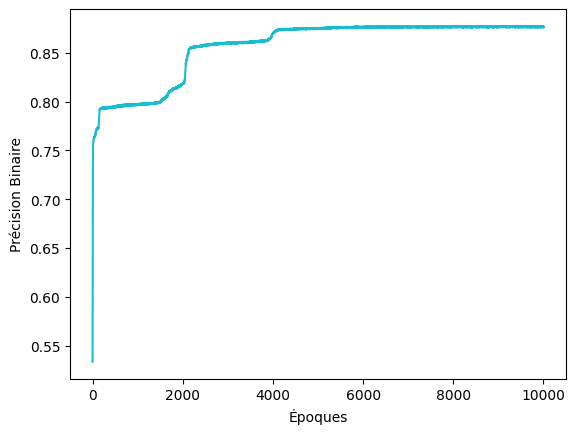

In [38]:
plot_history(history, '', show=False)
save_history('4,8,8,d10')